# Тестовое задание №1

Авиакомпании, помимо непосредственно продаж авиабилетов, зарабатывают еще и на продажах дополнительных услуг – возможности заранее забронировать себе место на верхней палубе самолета, ну или просто место с дополнительным местом для ног.

Требуется предсказать спрос на доп. услуги для рейсов из вкладки Тест с помощью любых open source python библиотек.

#### Описание данных:
- `Откудаё`и `куда` – коды аэропортов.  
- `ВС` – тип воздушного судна  
- `Мест на рейсе` – максимально доступное количество мест.  
- `Тип услуги` – название продаваемой услуги.  
- `Доступных мест услуги` – количество доступных мест этого типа на рейсе.  
- `Цена` – стоимость услуги в рублях.  


### План работы
1. [Первичный осмотр данных](#download)
2. [Анализ данных](#EDA)  
    2.1 [Анализ распределения данных во времени](#time)  
    2.2 [Aнализ данных с группировкой](group)      
    2.3 [Анализ корреляции данных](#cor)  
    2.4 [Выводы по анализу данных](#ac)  
3. [Построение модели](#model)  
    3.1 [Подготовка датасета](#model)  
    3.2 [CatBoost](#cat)  
    3.3 [LinearRegression](#LR)  
    3.4 [LGBM](#LGBM)  
4. [Выводы](#concl)
    

В следующей ячейке будут храниться импортированные библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from catboost import CatBoostRegressor
import lightgbm

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

### Первичный осмотр данных <a id='download'></a>

In [2]:
df = pd.read_excel('C:/Users/79153/Desktop/ya_projects/Problem1/Problem1.xlsx', sheet_name='Обучение')
test = pd.read_excel('C:/Users/79153/Desktop/ya_projects/Problem1/Problem1.xlsx', sheet_name='Тест')

In [3]:
display(df.head())
display(df.info())
display(df.describe())

,Дата рейса,Откуда,Куда,Продолжительность рейса,ВС,Мест на рейсе,Тип услуги,Доступных мест услуги,"Цена, руб",Фактический спрос
0,2018-03-31,VKO,HKT,> 6 часов,ВС1,522,A,45,1825.0,38
1,2018-03-31,VKO,HKT,> 6 часов,ВС1,522,SU,27,6205.0,23
2,2018-03-31,VKO,HKT,> 6 часов,ВС1,522,S,39,4380.0,18
3,2018-03-31,VKO,PRG,< 3 часов,ВС2,189,F,9,803.0,4
4,2018-03-30,VKO,HKT,> 6 часов,ВС1,522,A,45,1825.0,42


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Дата рейса               1750 non-null   datetime64[ns]
 1   Откуда                   1750 non-null   object        
 2   Куда                     1750 non-null   object        
 3   Продолжительность рейса  1750 non-null   object        
 4   ВС                       1750 non-null   object        
 5   Мест на рейсе            1750 non-null   int64         
 6   Тип услуги               1750 non-null   object        
 7   Доступных мест услуги    1750 non-null   int64         
 8   Цена, руб                1750 non-null   float64       
 9   Фактический спрос        1750 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 136.8+ KB


None

,Мест на рейсе,Доступных мест услуги,"Цена, руб",Фактический спрос
count,1750.000000,1750.000000,1750.000000,1750.000000
mean,439.001143,38.760000,2642.173714,19.693714
std,143.802128,44.247816,2310.424013,11.290028
min,189.000000,9.000000,362.500000,0.000000
25%,394.000000,27.000000,936.000000,11.000000
50%,522.000000,36.000000,1590.000000,18.000000
75%,522.000000,39.000000,3725.000000,26.000000
max,522.000000,339.000000,10530.000000,69.000000


In [4]:
display(test.head())
display(test.info())
display(test.describe())

,Дата рейса,Откуда,Куда,Продолжительность рейса,ВС,Мест на рейсе,Тип услуги,Доступных мест услуги,"Цена, руб"
0,2018-04-01,VKO,LCA,от 3 до 6 часов,ВС1,522,S,39,1460.0
1,2018-04-01,VKO,LCA,от 3 до 6 часов,ВС1,522,SU,27,2555.0
2,2018-04-01,VKO,PRG,< 3 часов,ВС2,189,F,9,803.0
3,2018-04-02,VKO,BKK,> 6 часов,ВС1,522,A,45,1168.0
4,2018-04-02,VKO,HKT,> 6 часов,ВС1,522,A,45,1825.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Дата рейса               162 non-null    datetime64[ns]
 1   Откуда                   162 non-null    object        
 2   Куда                     162 non-null    object        
 3   Продолжительность рейса  162 non-null    object        
 4   ВС                       162 non-null    object        
 5   Мест на рейсе            162 non-null    int64         
 6   Тип услуги               162 non-null    object        
 7   Доступных мест услуги    162 non-null    int64         
 8   Цена, руб                162 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 11.5+ KB


None

,Мест на рейсе,Доступных мест услуги,"Цена, руб"
count,162.000000,162.000000,162.000000
mean,460.333333,45.216049,2910.919753
std,129.754187,57.314401,2300.913913
min,189.000000,9.000000,360.000000
25%,522.000000,27.000000,900.000000
50%,522.000000,39.000000,1837.500000
75%,522.000000,45.000000,4410.000000
max,522.000000,275.000000,9720.000000


Осмотрим уникальные значения категориальных признаков

In [5]:
df['Продолжительность рейса'].unique()

array(['> 6 часов', '< 3 часов', 'от 3 до 6 часов'], dtype=object)

In [6]:
df['ВС'].unique()

array(['ВС1', 'ВС2'], dtype=object)

In [7]:
df['Тип услуги'].unique()

array(['A', 'SU', 'S', 'F', 'C'], dtype=object)

In [8]:
print(df['Откуда'].unique())
print(df['Куда'].unique())

['VKO' 'LED' 'OVB' 'PEE' 'OMS' 'SVX' 'CEK']
['HKT' 'PRG' 'PUJ' 'BKK' 'SHJ' 'DXB' 'LCA' 'NBE' 'CFU' 'BCN' 'HER' 'RHO']


Проверим вместимость воздушных судов

In [9]:
df[df['ВС']=='ВС1']['Мест на рейсе'].unique()

array([522, 373, 457], dtype=int64)

In [10]:
df[df['ВС']=='ВС2']['Мест на рейсе'].unique()

array([189], dtype=int64)

Осмотрим временной интервал

In [11]:
print('Наиболее поздняя дата: ' + str(max(df['Дата рейса'])))
print('Наиболее ранняя дата: '+ str(min(df['Дата рейса'])))

Наиболее поздняя дата: 2018-03-31 00:00:00
Наиболее ранняя дата: 2016-10-01 00:00:00


In [12]:
print('Наиболее поздняя дата: ' + str(max(test['Дата рейса'])))
print('Наиболее ранняя дата: '+ str(min(test['Дата рейса'])))

Наиболее поздняя дата: 2018-04-30 00:00:00
Наиболее ранняя дата: 2018-04-01 00:00:00


Проверка на явные дубликаты

In [13]:
print(f'Число дубликатов в датасете: {df.duplicated().sum()}')

Число дубликатов в датасете: 39


In [14]:
df = df.drop_duplicates().reset_index(drop=True)
print(f'Число дубликатов в датасете: {df.duplicated().sum()}')

Число дубликатов в датасете: 0


Выводы: 

1. Пропусков нет.
2. Неявных дубликатов нет.
3. Достаточно большой период для обучения, период под тест занимает всего месяц.
4. Тип воздушного судна по сути уже закодирован во вместимости судна.
5. Явные дубликаты удалены


### Анализ данных <a id='EDA'></a>

Построим гистограммы

Гистограммы для услуги A
---------------------------------------------


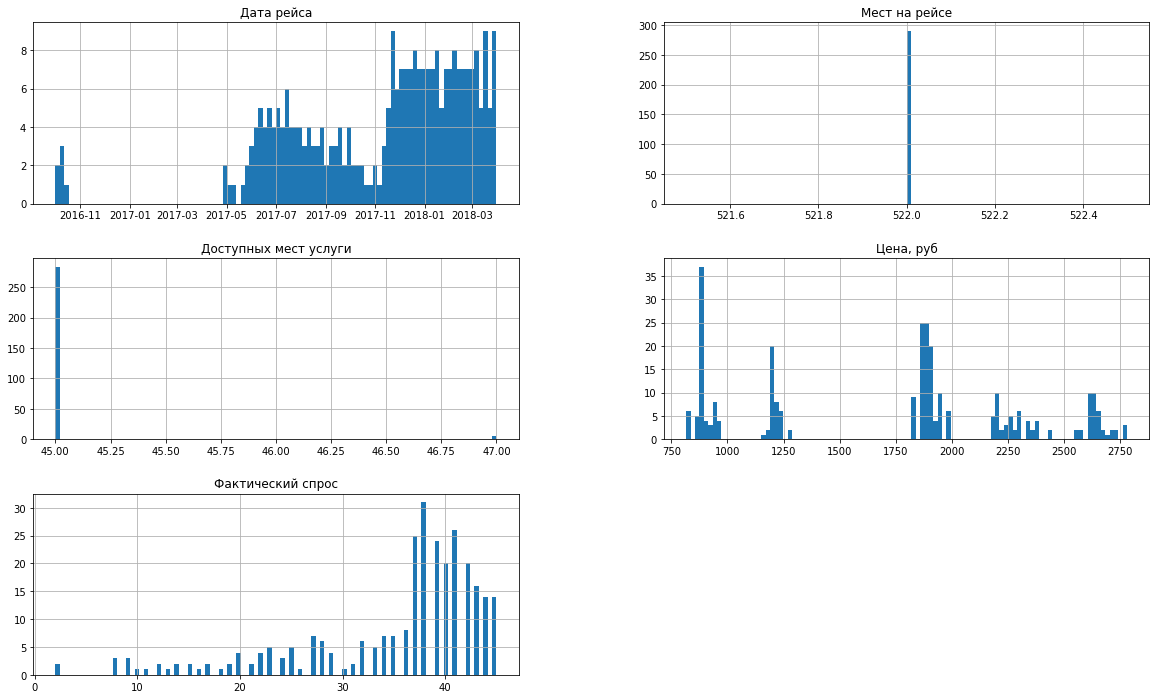

Гистограммы для услуги SU
---------------------------------------------


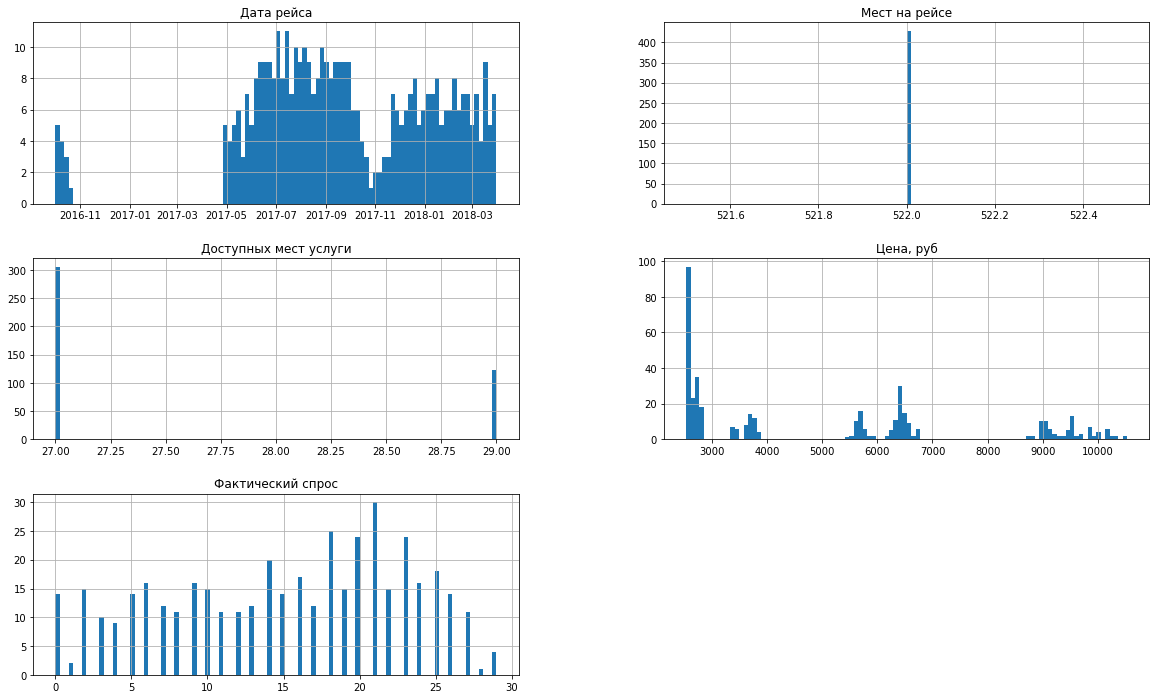

Гистограммы для услуги S
---------------------------------------------


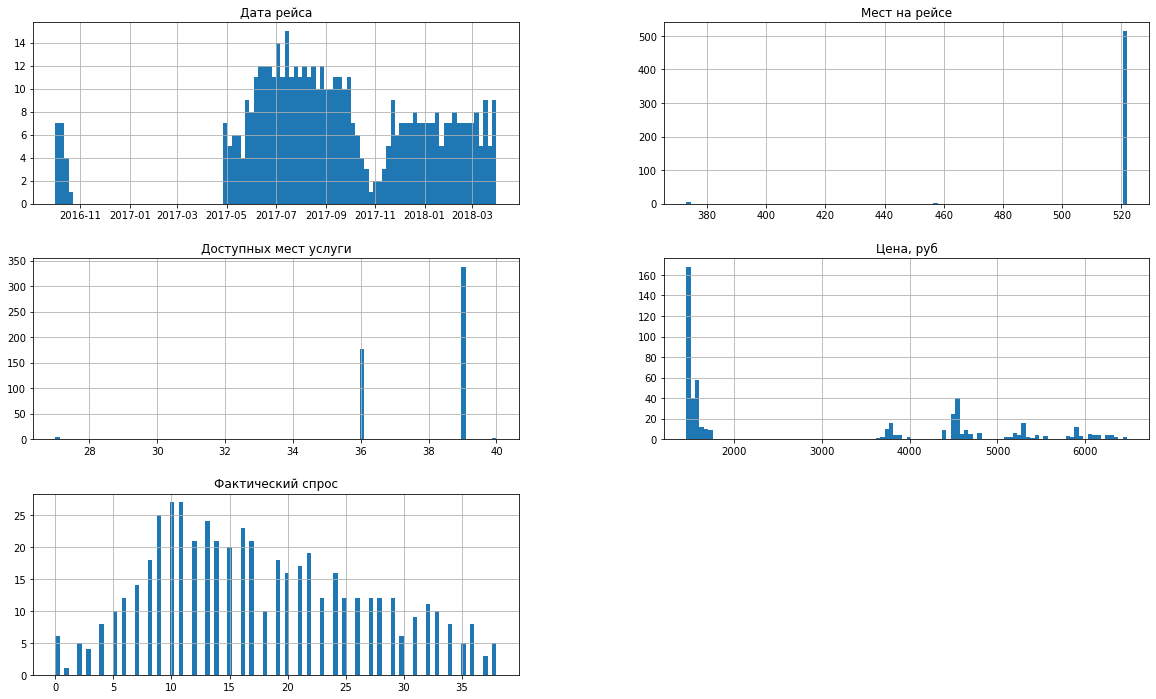

Гистограммы для услуги F
---------------------------------------------


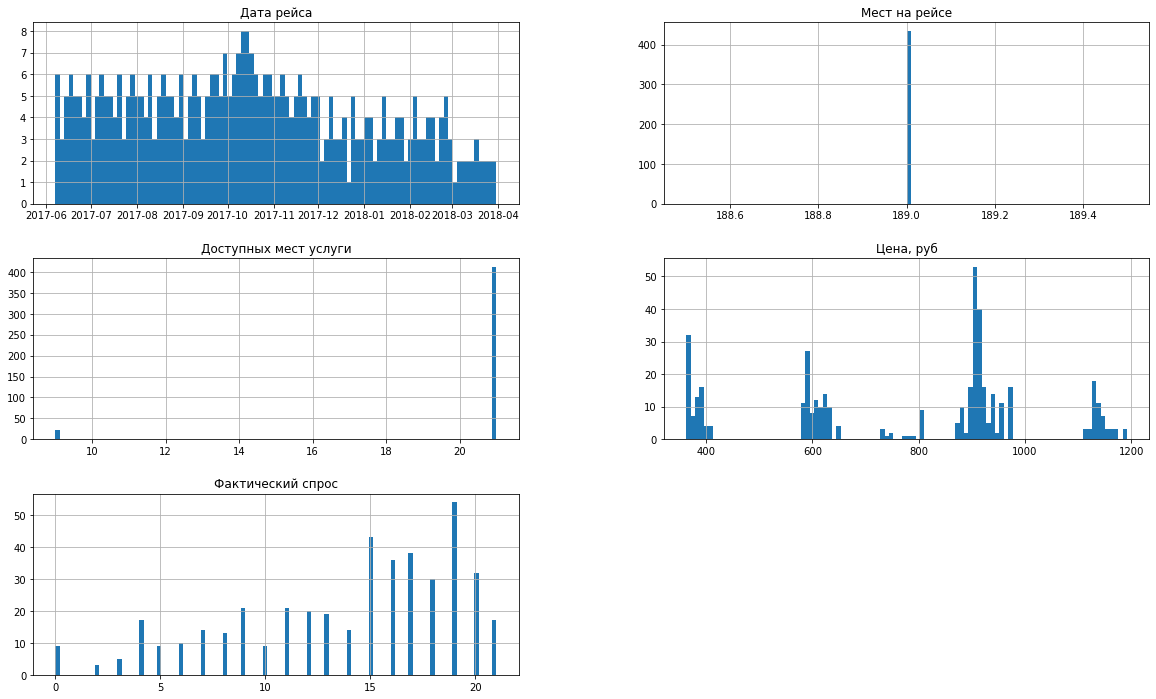

Гистограммы для услуги C
---------------------------------------------


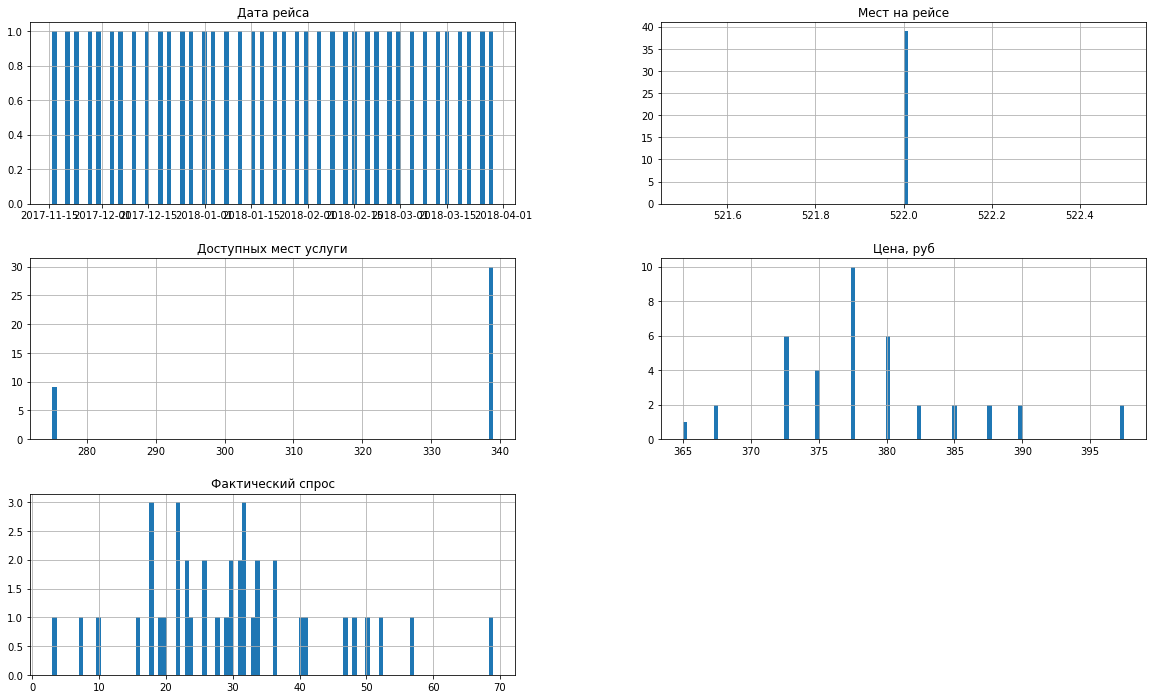

In [15]:
services = df['Тип услуги'].unique()

for service in services:
    print('Гистограммы для услуги '+ str(service))
    df[df['Тип услуги'] == service].hist(figsize=(20,12), bins=100)
    print('---'*15)
    plt.show()

Вывод:
1. Некоторые услуги предлагаются на бортах определенной вместимости.
2. В данных есть пробел с декабря 2016 по апрель 2017 для услуг А, S и SU, так же есть определенный спад за октябрь-ноябрь 2017 - вероятно это просто отсутствие данных, а не закономерность.

Введем несколько новых столбцов

In [16]:
df['Прибыль'] = df['Цена, руб']*df['Фактический спрос']
df['Конверсия'] = df['Фактический спрос']/df['Доступных мест услуги']
df['День недели'] = df['Дата рейса'].dt.dayofweek.astype('object')
df['Год'] = df['Дата рейса'].dt.year.astype('object')

#### Анализ распределения данных во времени <a id='time'></a>
Введем функцию для анализа распределения данных по времени 

In [17]:
def dependence (first, second, third):
    for j in df[first].unique():

        fig = plt.figure(figsize=(16, 8))
        fig.suptitle(str(j),  fontsize=20)

        df_1 = df[df[first] == j]

        ax1 = fig.add_subplot()
    
        times = df[second].unique()
        
        for i in range(len(df[second].unique())):
            df_2 = df_1[df_1[second] == times[i]]
        
            colors = ['b', 'black', 'r','g', 'y', 'gray', 'gold', 'c', 'm','b', 'black', 'r']
            markers = ['s','o', '^', '>','<', '.', 's','o', '^', '>','<', '+']
        
            ax1.scatter(df_2['Дата рейса'], df_2[third], s=10, c=colors[i], marker=markers[i], label=times[i], alpha=0.75)

            plt.ylabel(third)
            plt.legend(loc='upper left')
            ax1.patch.set_facecolor('#F0FFFF')
            plt.grid()

        plt.show()

Проверим распределение цен в зависимости от продолжительности рейса и типа услуги

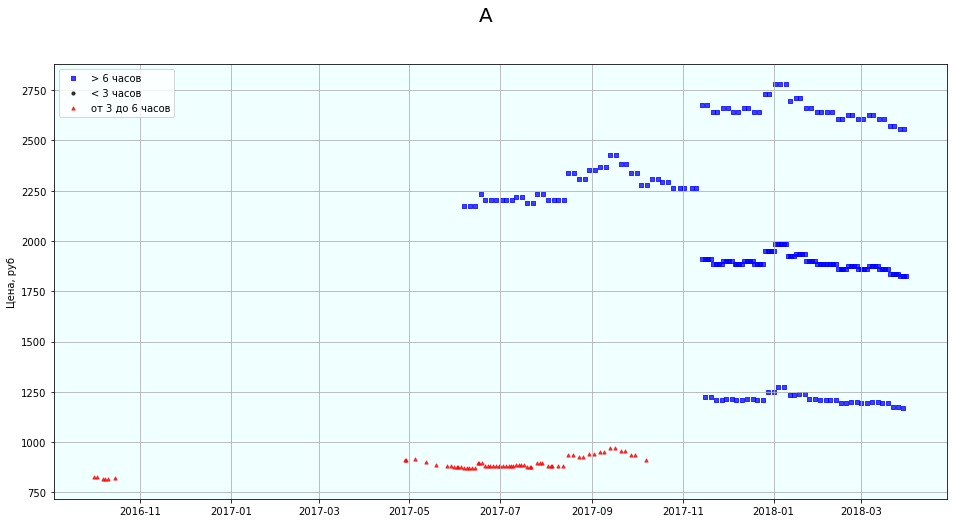

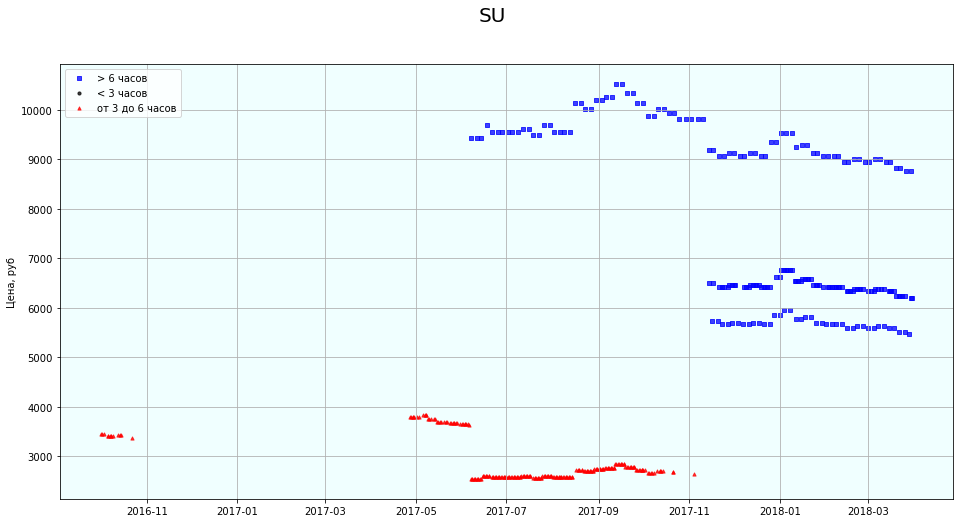

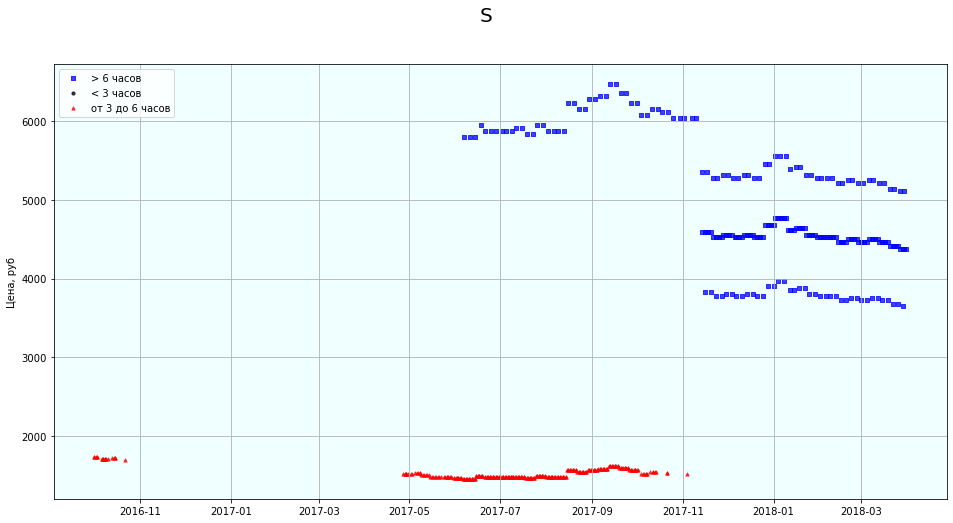

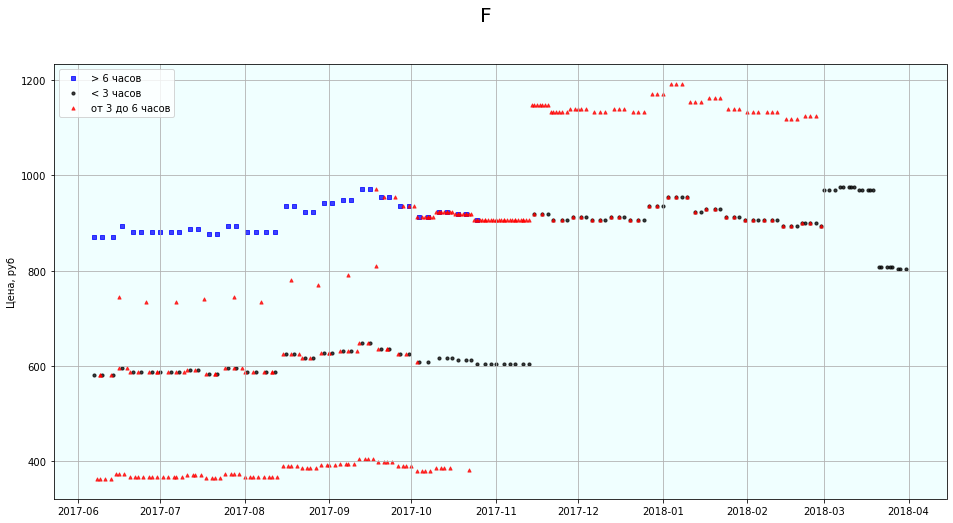

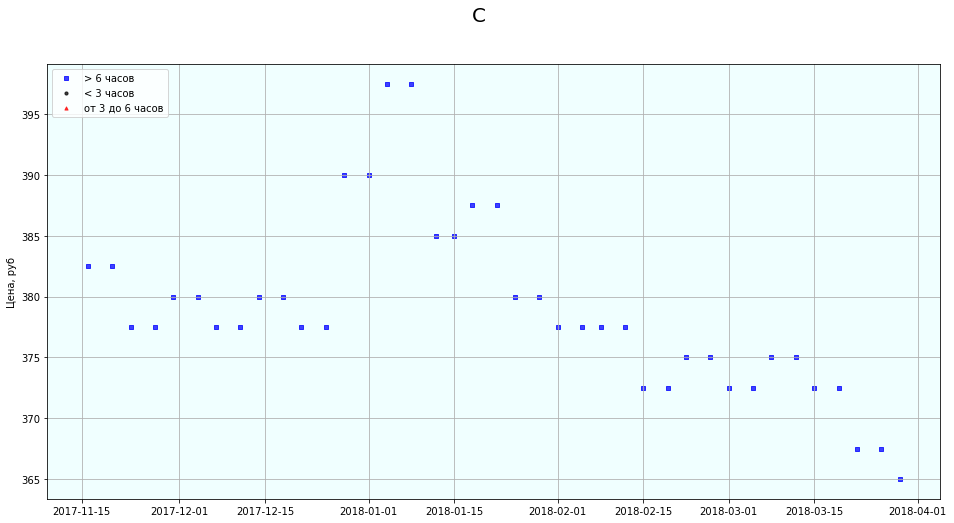

In [18]:
dependence ('Тип услуги', 'Продолжительность рейса', 'Цена, руб')

1. Услуга С предоставляется исключительно на рейсах >6 часов
2. Все услуги на рейсах >6 часов стоят дороже, кроме услуги F
3. В данных есть пробелы - некоторые услуги не продавались часть временного интервала, либо же в датасете отсутствуют данные по ним за эти периоды.
4. Флуктация цен во времени не значительна и видимо определяется каким-то другим параметром кроме длительности полета (скорее всего точкой отправления или прилета).

Рассмотрим более важный параметр - конверсию.

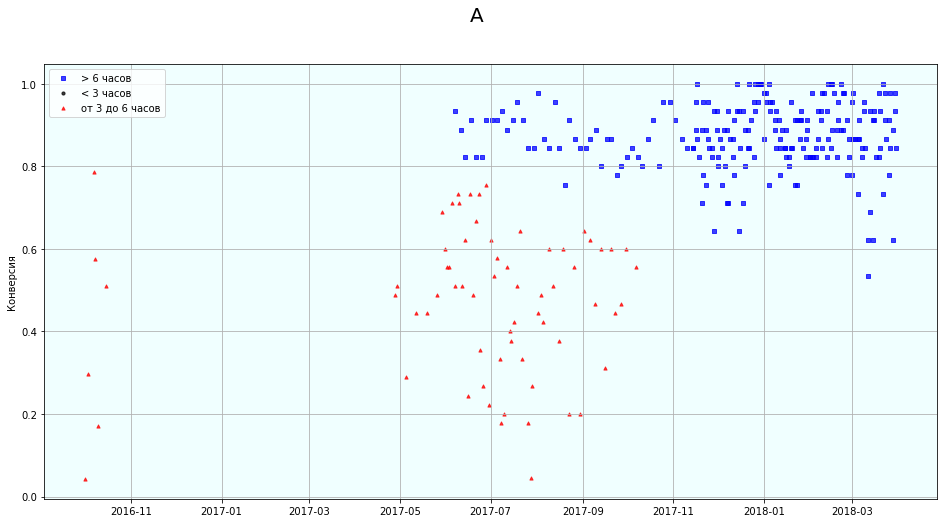

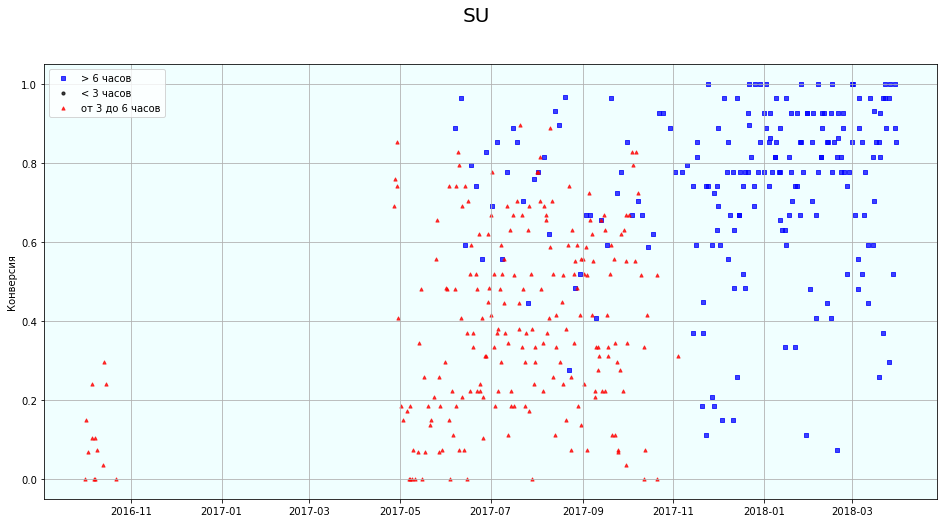

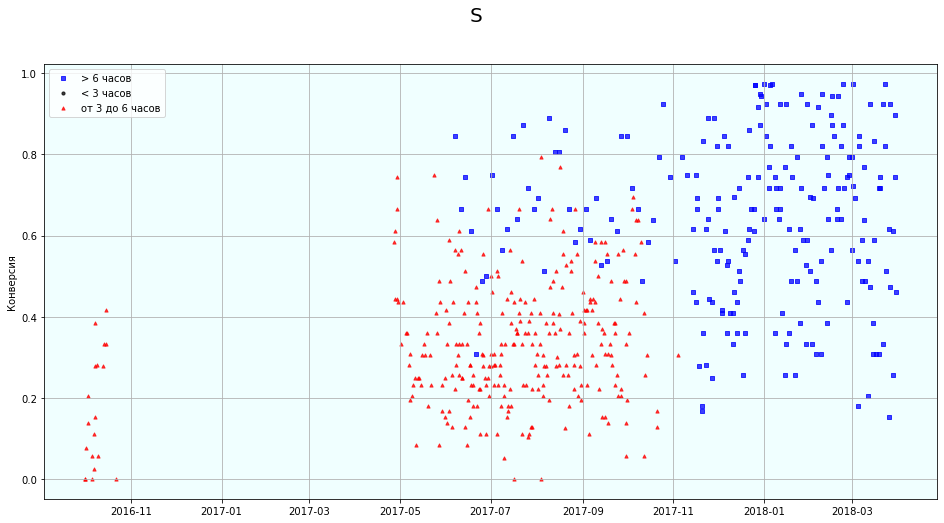

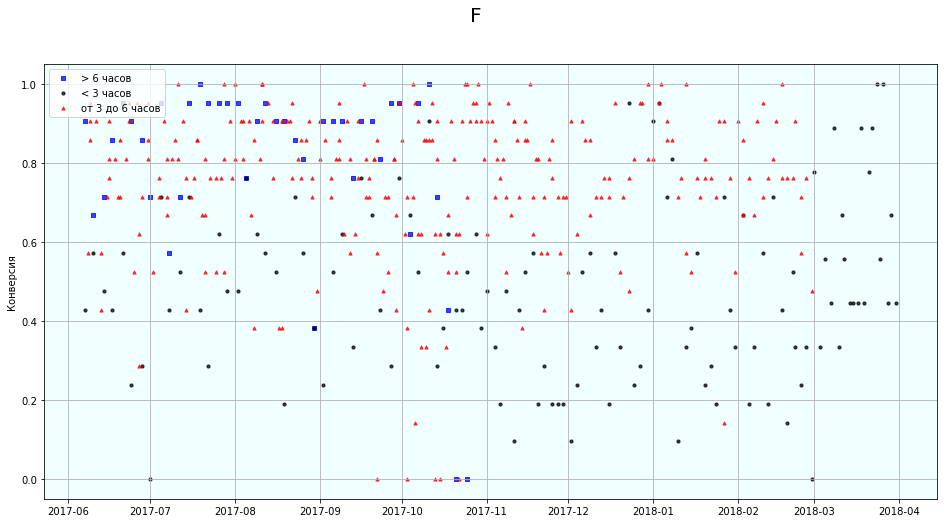

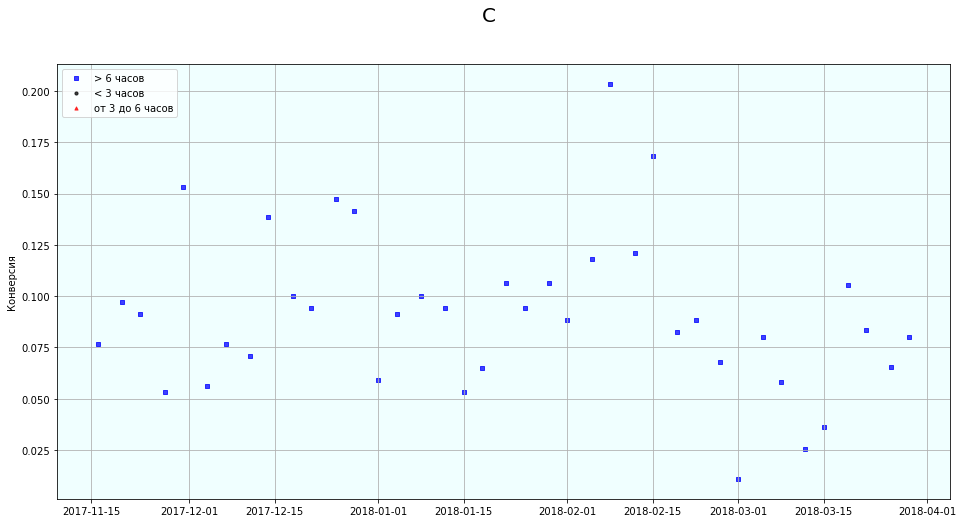

In [19]:
dependence ('Тип услуги', 'Продолжительность рейса', 'Конверсия')

1. Исключая услуги F и C, конверсия на рейсах длительностью более 6 часов выше, чем на рейсах от3 до 6 и менее 3 часов.  

Рассмотрим прибыль

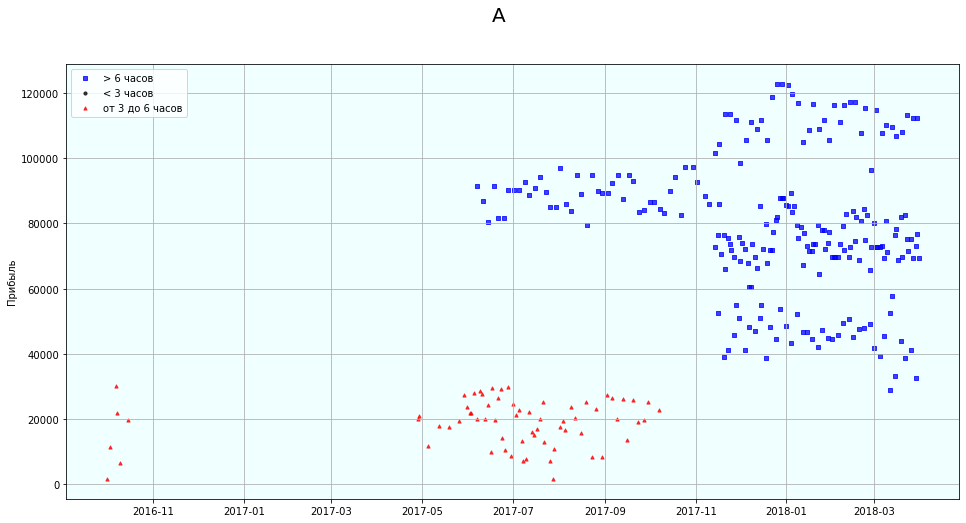

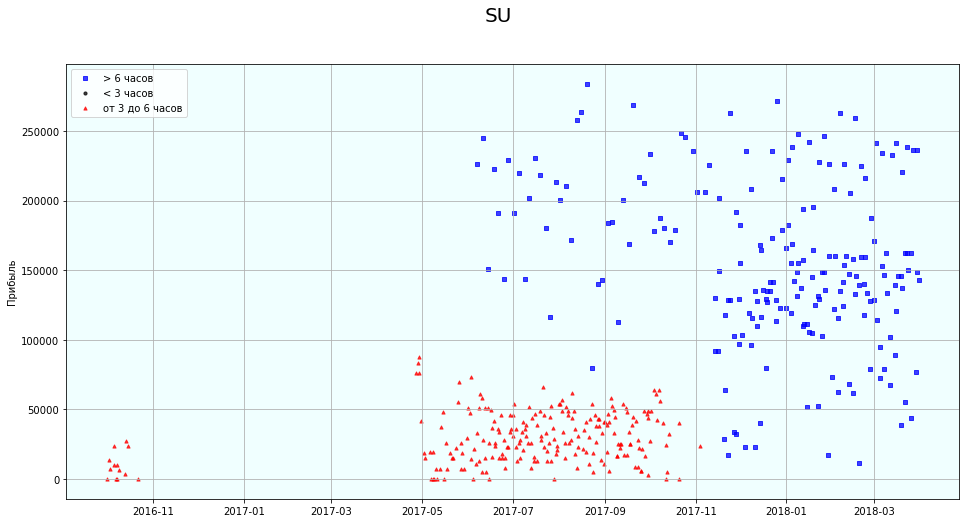

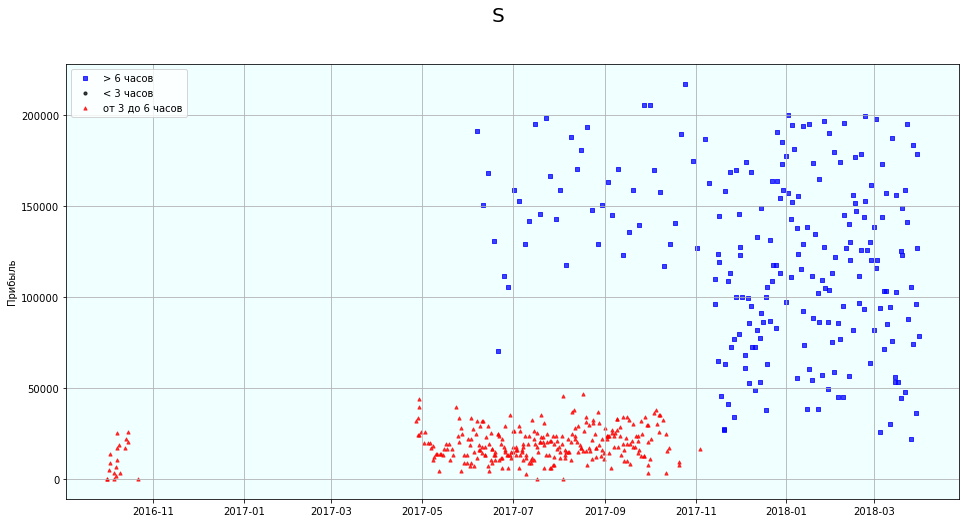

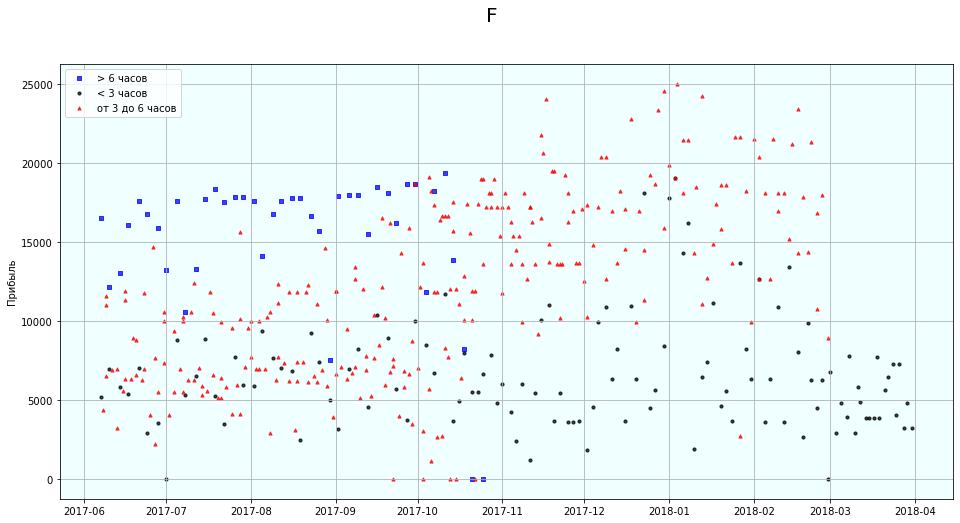

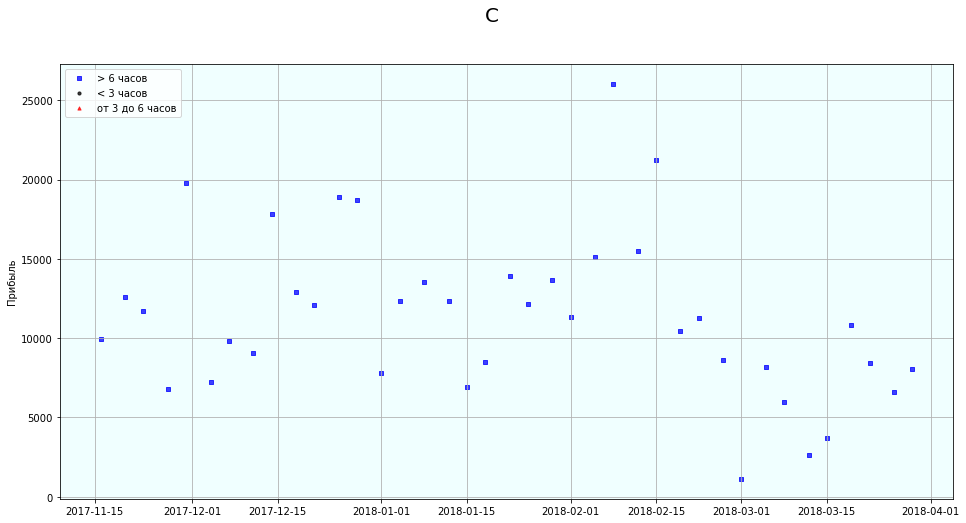

In [20]:
dependence ('Тип услуги', 'Продолжительность рейса', 'Прибыль')

Диаграммы прибыли по сути соединяют в себе две предыдущие и подтверждают их, интересны разрывы в прибыли в услугах A,S и SU по продолжительности рейсов. Учитывая сниженную конверсию для этих услуг на полетох 3-6 часов имеет смысл повысить их рентабельность.

Рассмотрим зависимость конверсии услуг от пункта отправления

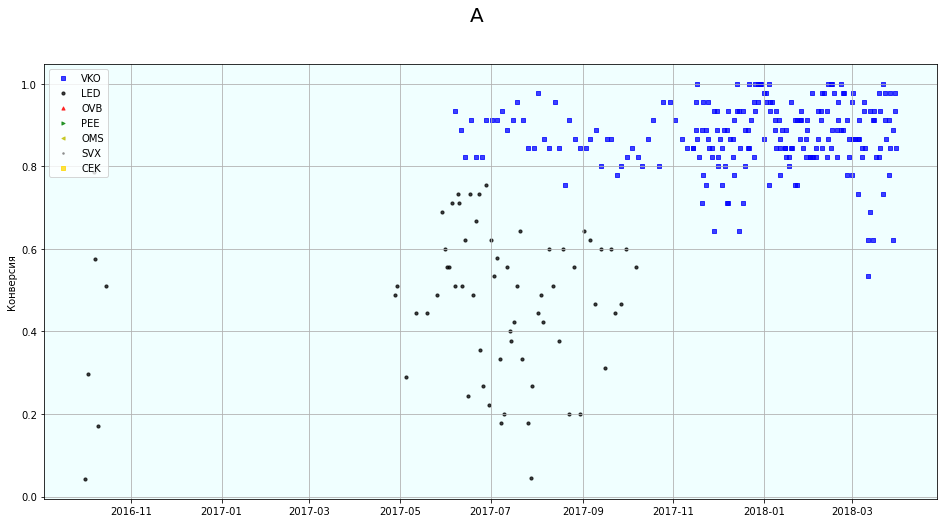

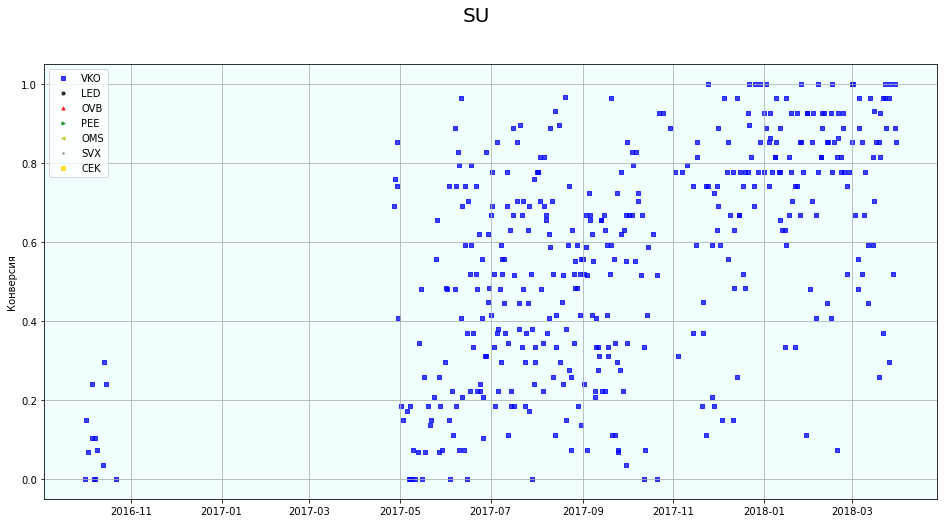

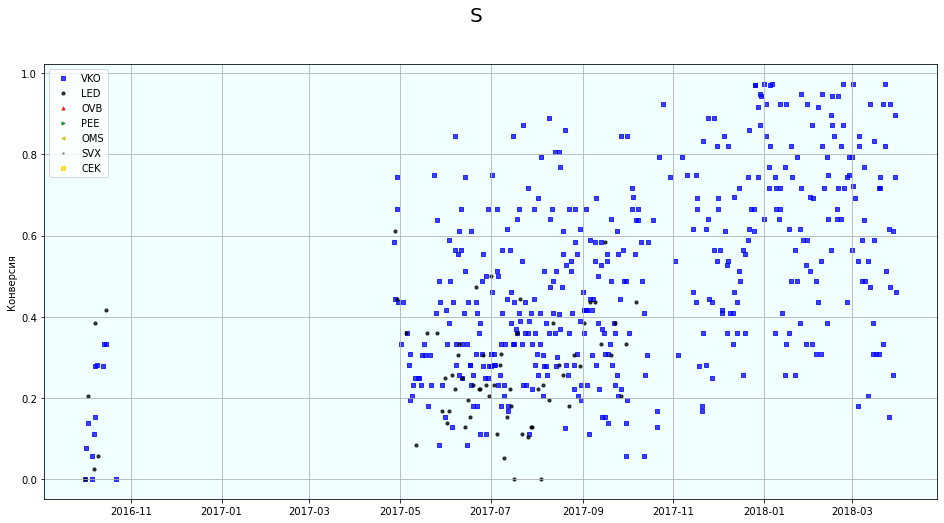

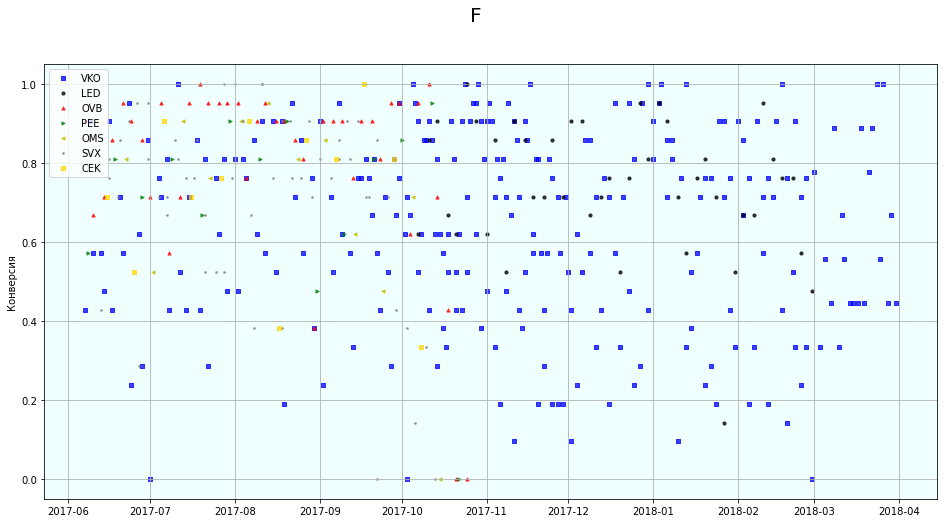

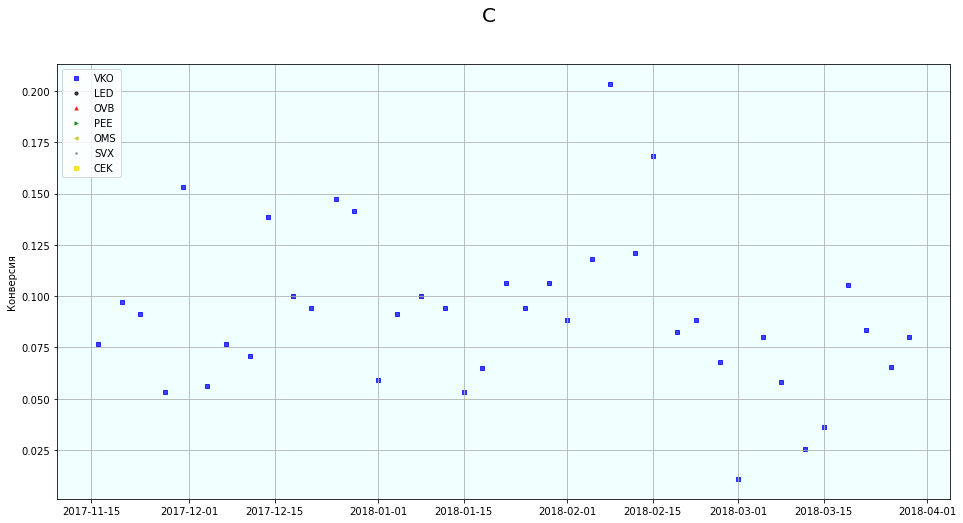

In [21]:
dependence ('Тип услуги', 'Откуда', 'Конверсия')

1. По всем услугам кроме F лидирует Внуково, на втором месте Пулково.
2. A, SU, S, C предоставляются преимущественно Внуково и частично Пулково. 
3. Услуга F предоставляется всеми аэропортами.

Посмотрим конверсию в разрезе длительности рейса и точки отправления

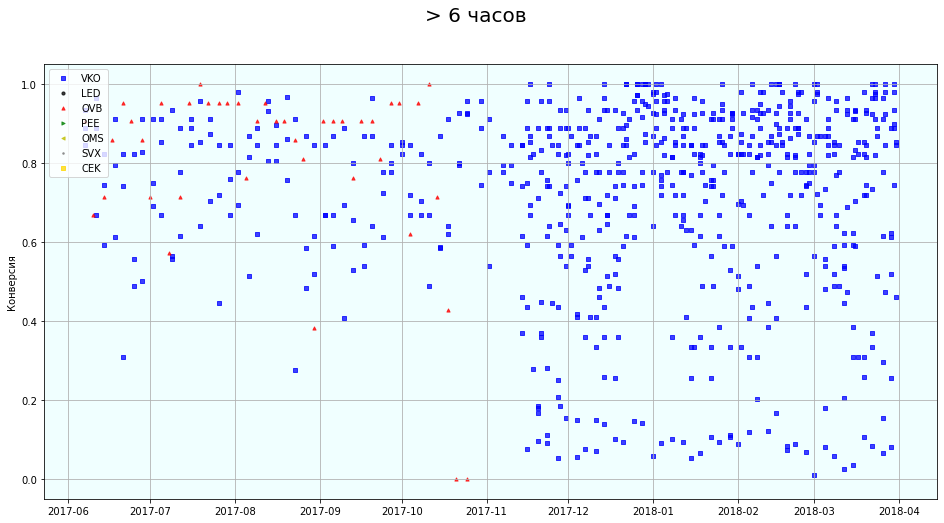

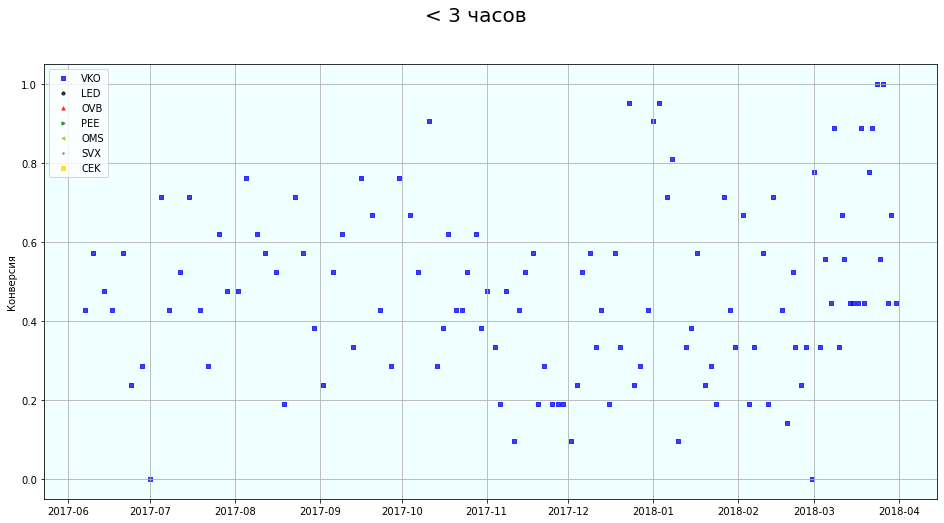

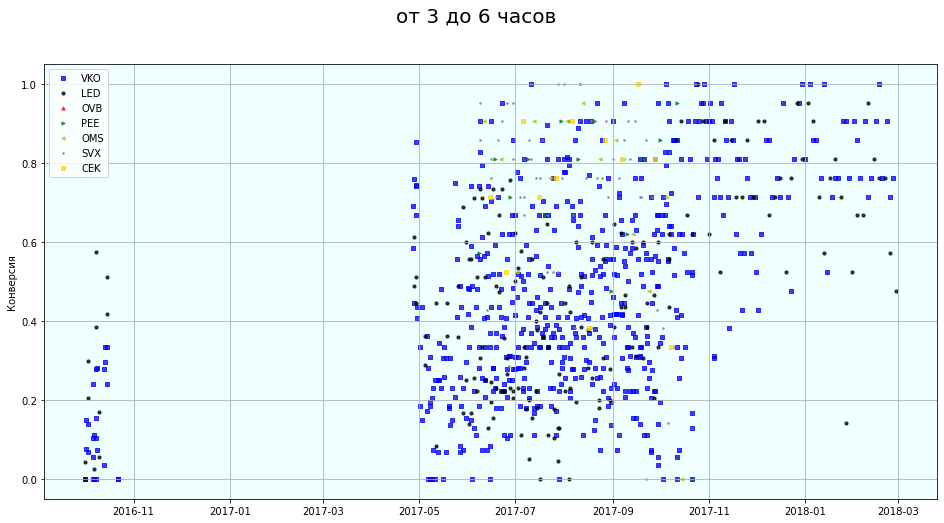

In [22]:
dependence ('Продолжительность рейса', 'Откуда', 'Конверсия')

1. Внуково доминирует на рынке перелетов свыше 6 часов и менее 3.
2. На рейсах средней длительности конверсия Внуково и Пулково не так велика, как у других аэропортов.

Рассмотрим тоже в разрезе типа судов

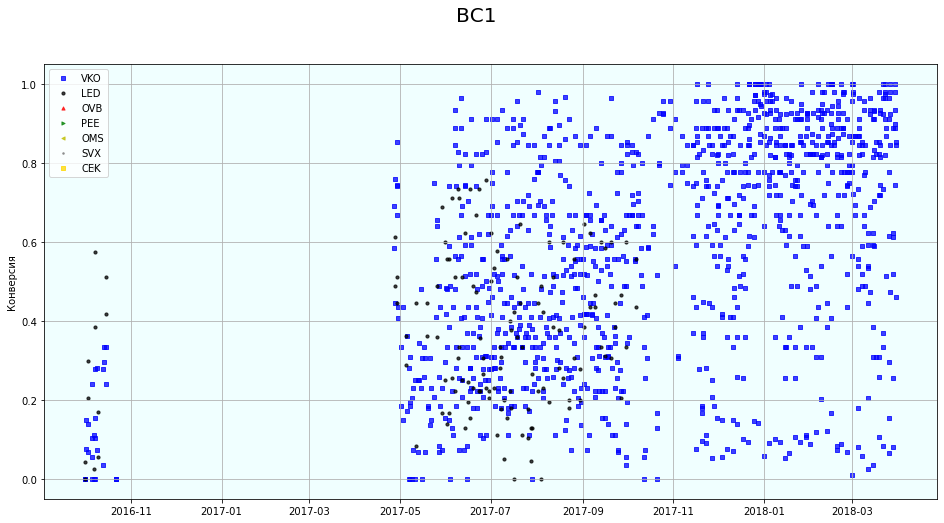

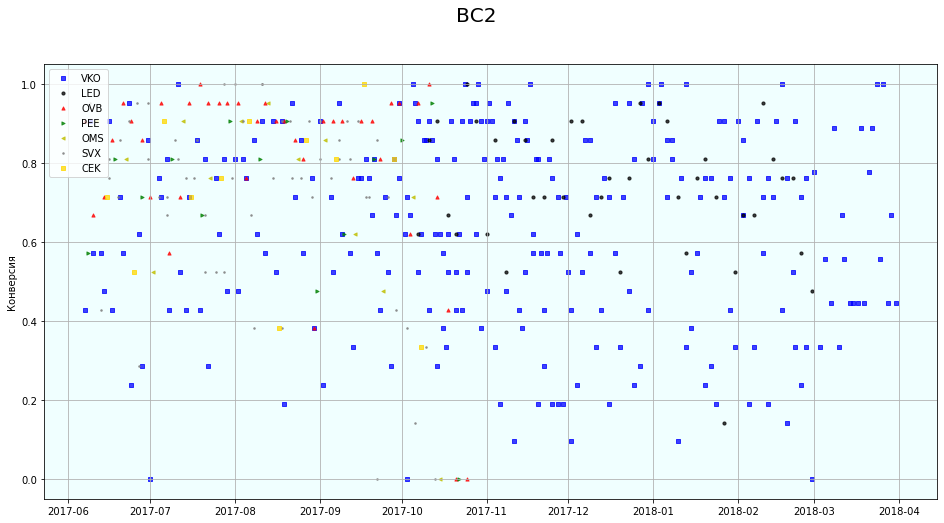

In [23]:
dependence ('ВС', 'Откуда', 'Конверсия')

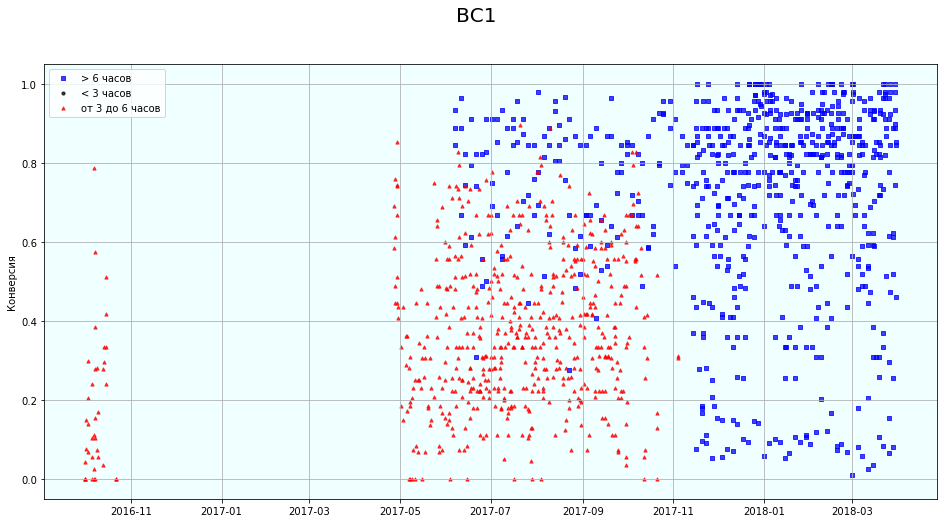

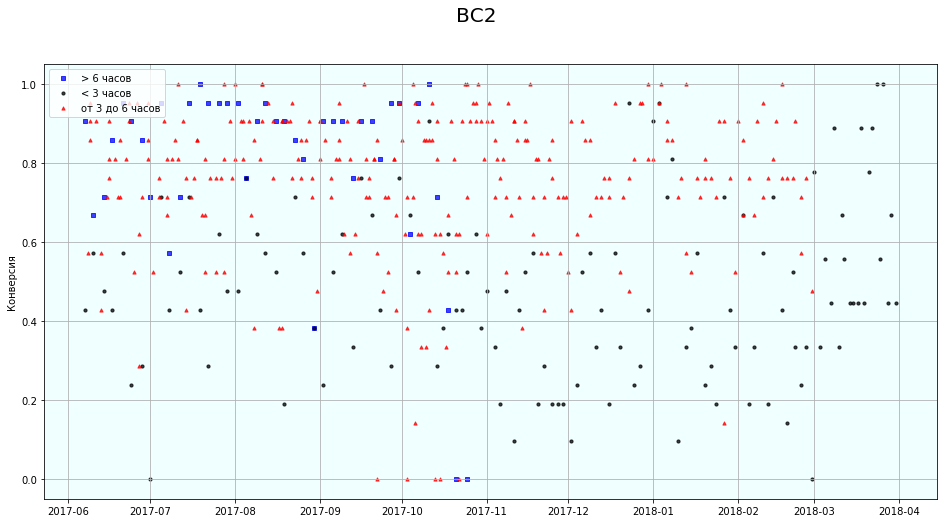

In [24]:
dependence ('ВС', 'Продолжительность рейса', 'Конверсия')

1. Только Внуково и Пулково  работают с судами типа ВС1.
2. ВС1 работает только на длительных и средних перелетах.

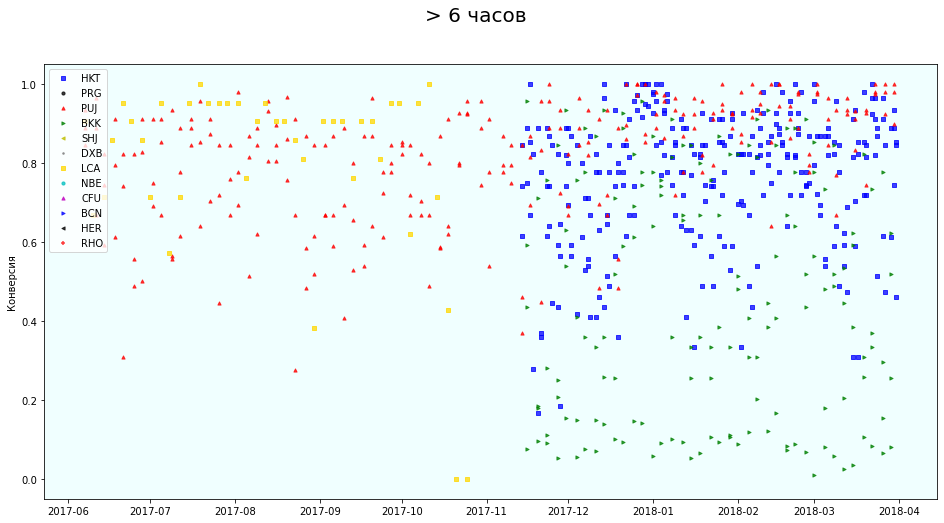

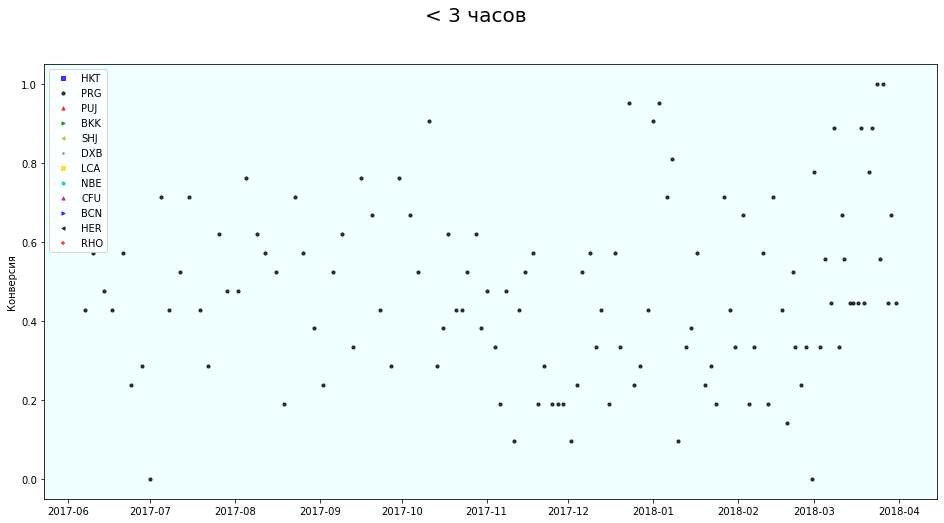

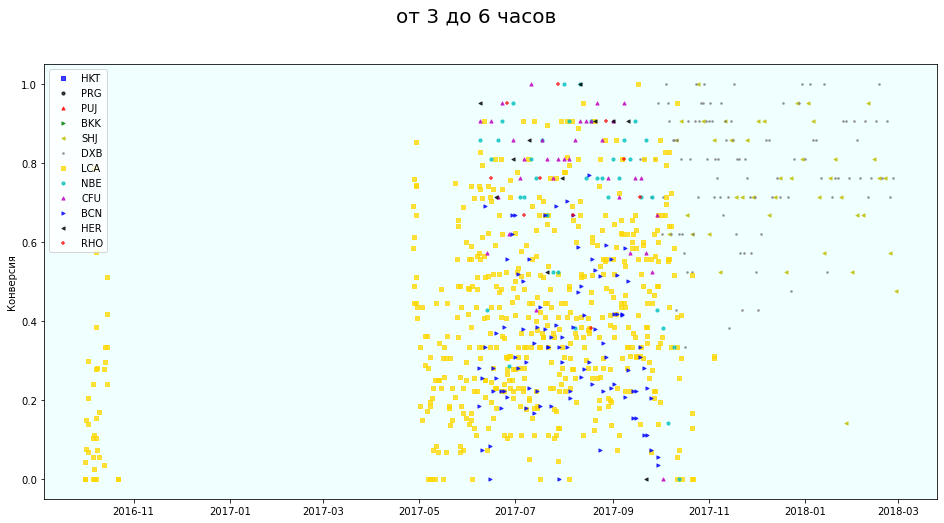

In [25]:
dependence ('Продолжительность рейса', 'Куда', 'Конверсия')

1. Рассеяние очень большое
2. Рейсы менее 3 часов летят исключительно в PRG
3. Часть данных утеряна\не выгружена

#### Aнализ данных с группировкой <a id='group'></a>  
Запишем функцию для отображения однотипных группировок данных

In [26]:
def group_diagr(col):
    fig,ax = plt.subplots(1,4,figsize = (18,12))
    df.groupby(col)['Прибыль'].count().plot(ax=ax[0],
                                         kind='bar', 
                                         figsize=(16,8), 
                                         grid=True,
                                         title='Количество рейсов за период',
                                         alpha=0.75)
    df.groupby(col)['Прибыль'].sum().plot(ax=ax[1],
                                         kind='bar', 
                                         figsize=(16,8), 
                                         grid=True,
                                         title='Прибыль за период,р',
                                         alpha=0.75)
    df.groupby(col)['Цена, руб'].mean().plot(ax=ax[2],
                                         kind='bar', 
                                         figsize=(16,8), 
                                         grid=True,
                                         title='Средняя цена за период,р',
                                         alpha=0.75)
    df.groupby(col)['Конверсия'].mean().plot(ax=ax[3],
                                         kind='bar', 
                                         figsize=(16,8), 
                                         grid=True,
                                         title='Средняя конверсия за период',
                                         alpha=0.75)
    plt.show()

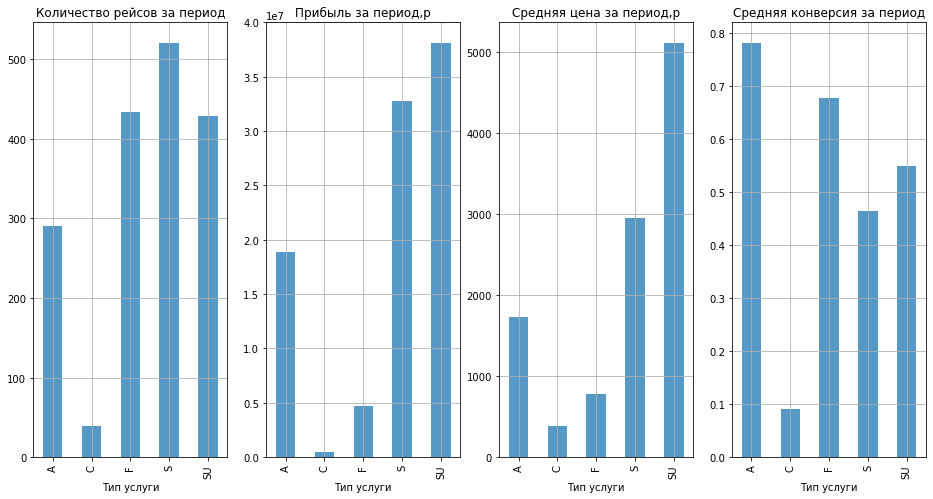

In [27]:
group_diagr('Тип услуги')

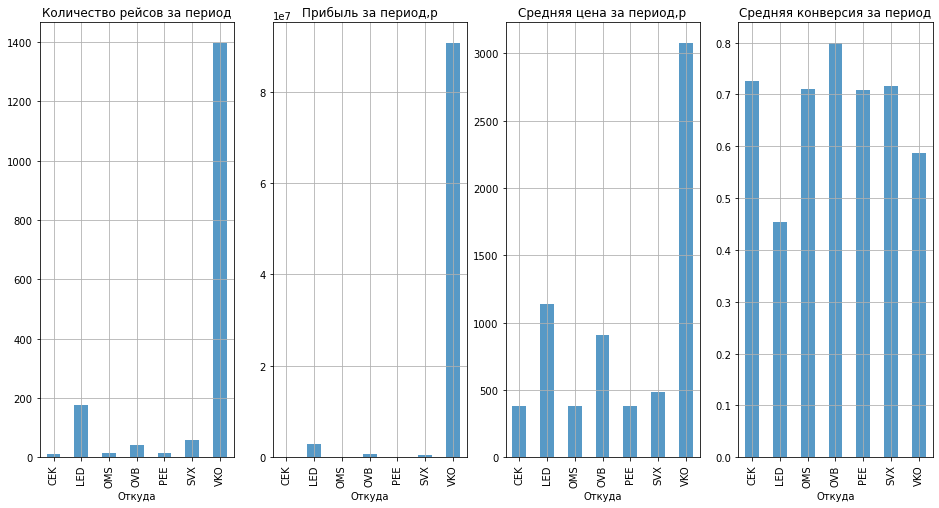

In [28]:
group_diagr('Откуда')

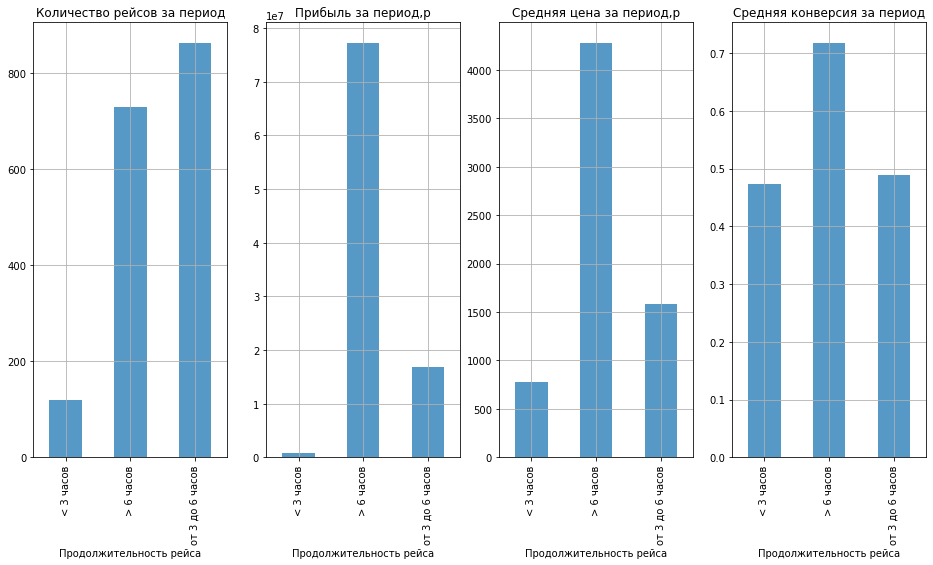

In [29]:
group_diagr('Продолжительность рейса')

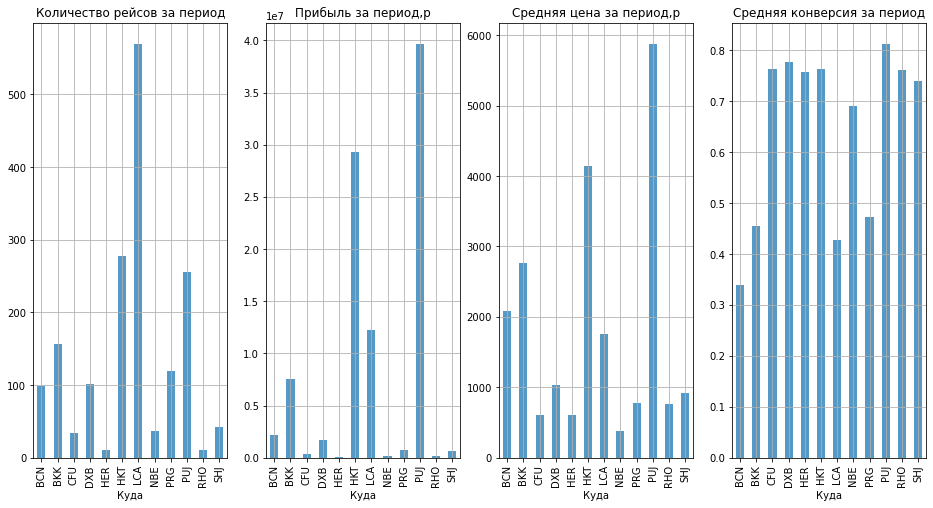

In [30]:
group_diagr('Куда')

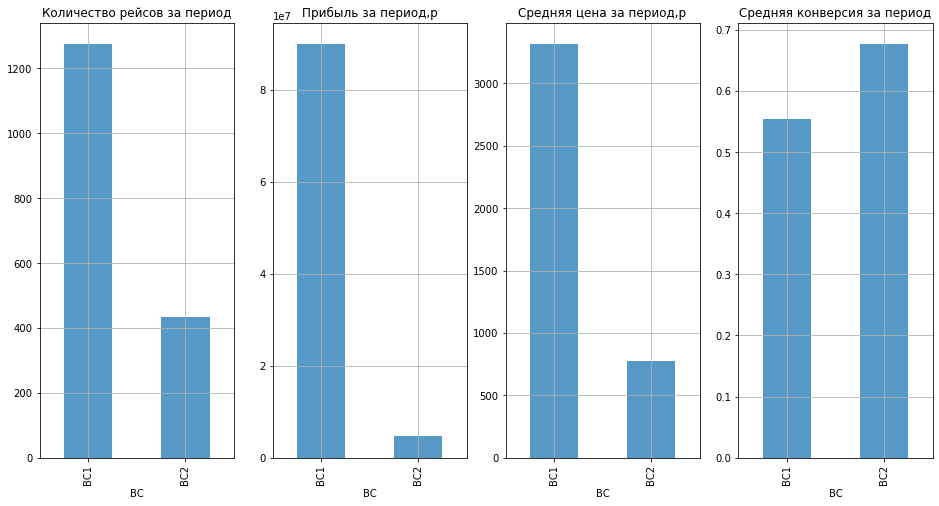

In [31]:
group_diagr('ВС')

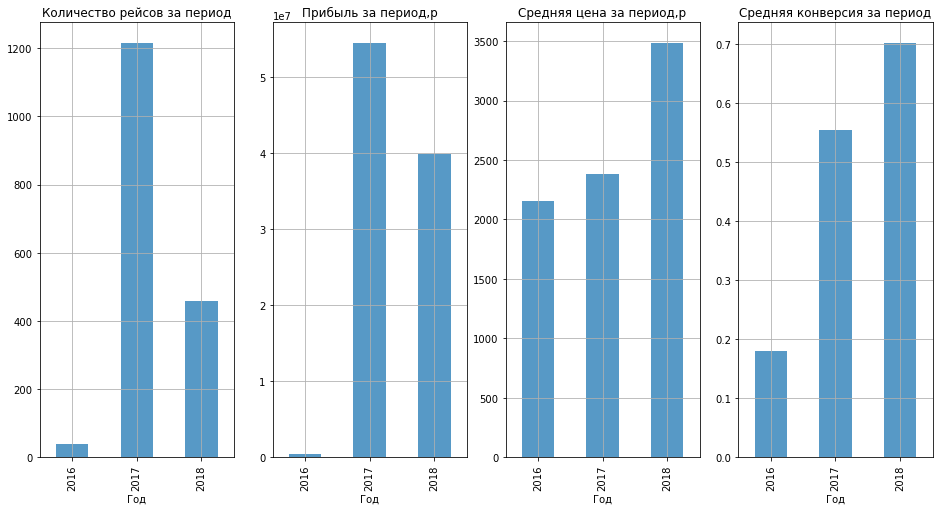

In [32]:
group_diagr('Год')

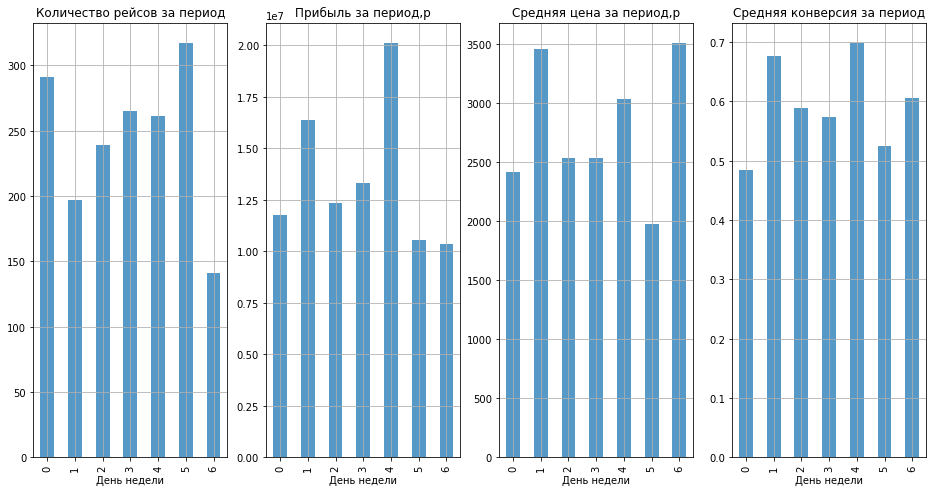

In [33]:
group_diagr('День недели')

#### Анализ корреляции данных <a id='cor'></a>
Проверим корреляцию данных

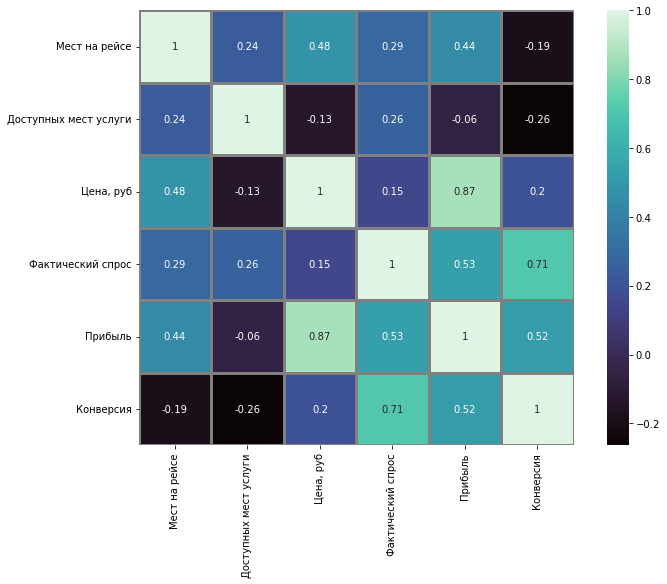

In [34]:
plt.subplots(1,1,figsize = (12,8))
sns.heatmap(df.corr(), cmap="mako",square=True, linewidths=3, linecolor='gray', annot=True)
plt.show()

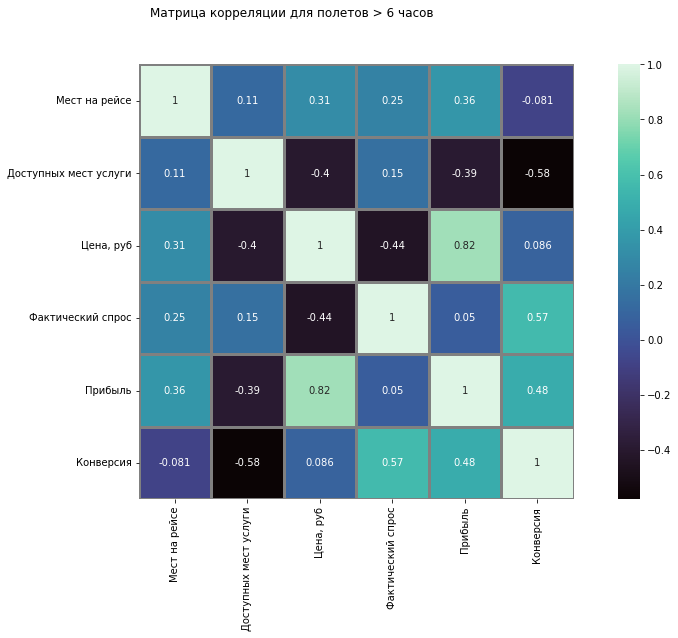

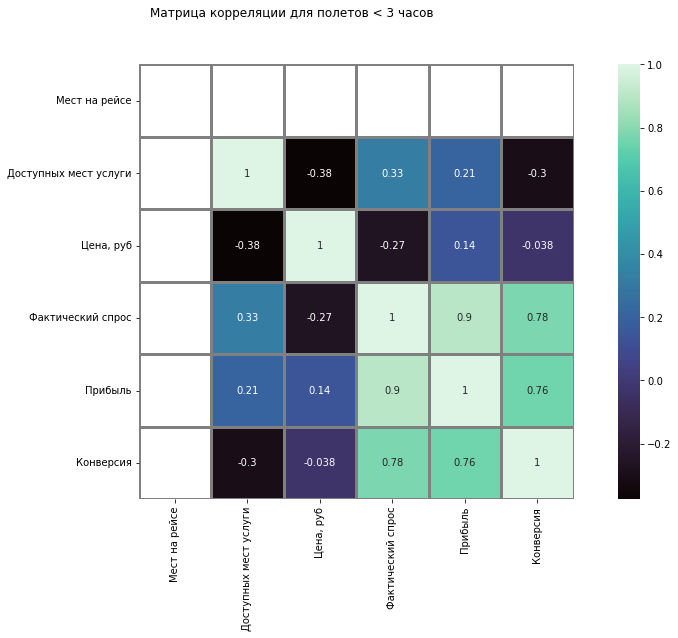

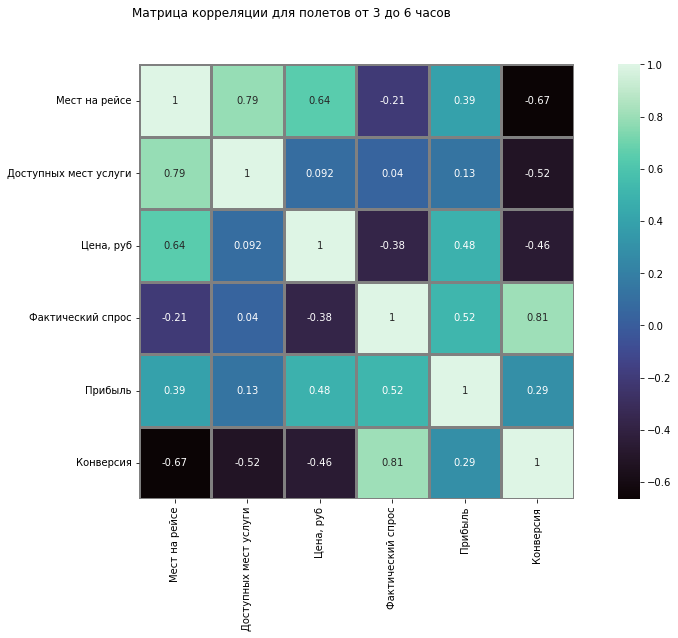

In [35]:
for i in df['Продолжительность рейса'].unique():
    fig = plt.figure(figsize=(16, 8))
    
    fig.suptitle('Матрица корреляции для полетов '+str(i))
    sns.heatmap(df[df['Продолжительность рейса']==i].corr(), cmap="mako",square=True, linewidths=3, linecolor='gray', annot=True)
    plt.show()

1. В данном случае цена умеренно-слабо коррелирует с фактическим спросом, но в разрезе длительности полета. 
2. Доступные места услуги коррелируют только при длительности полета менее 3 часов.
3. "Мест на рейсе" коррелирует слабо с фактическим спросом - оказывает влияние на цену, так же в этот параметр заложен тип судна и как следствие часть маршрутов и услуг.

#### Выводы <a id='ac'></a>
1. Часть услуг торгуется только при вылете определенными аэропортами.
2. Некоторые услуги доступны только при полетах определенной длительности.
3. Большинство аэропортов принимает только суда типа ВС2. При этом маршруты средней и высокой дальности доступны только ВС1. 
4. Среди числовых данных корреляцию показывает только цена в разрезе длительности полета. Цена услуги определяется в первую очередь пунктом отправки и длительностью полета. Существенного изменения цены во времени нет.
5. Есть отсутствующие данные за определенные периоды времени
6. Услуги имеют различную среднюю конверсию и доступны не на всех аэропортах, типах ВС и дальностях полетов. 

### Построение модели <a id='model'></a>

Выполним подготовку данных 

In [36]:
prep_df = df.copy()
prep_df['Мест на рейсе'] = prep_df['Мест на рейсе'].astype('object')
prep_df['День недели'] = prep_df['Дата рейса'].dt.dayofweek.astype('object')        
prep_df.drop(['Куда','Дата рейса','Прибыль', 'Конверсия', 'Год', 'ВС', 'День недели', 'Доступных мест услуги'], axis=1, inplace=True)
prep_df.head()

,Откуда,Продолжительность рейса,Мест на рейсе,Тип услуги,"Цена, руб",Фактический спрос
0,VKO,> 6 часов,522,A,1825.0,38
1,VKO,> 6 часов,522,SU,6205.0,23
2,VKO,> 6 часов,522,S,4380.0,18
3,VKO,< 3 часов,189,F,803.0,4
4,VKO,> 6 часов,522,A,1825.0,42


In [37]:
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711 entries, 0 to 1710
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Откуда                   1711 non-null   object 
 1   Продолжительность рейса  1711 non-null   object 
 2   Мест на рейсе            1711 non-null   object 
 3   Тип услуги               1711 non-null   object 
 4   Цена, руб                1711 non-null   float64
 5   Фактический спрос        1711 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 80.3+ KB


In [38]:
# сбор результатов
scores = pd.DataFrame()

def total_results(name):
    score = scores.append({'model' : name,
                   'R2' : r2_score(y_test, prediction).round(5),
                   'RMSE' : ((mean_squared_error(y_test, prediction))**0.5).round(4)}, ignore_index = True)
    return score

#### CatBoostRegressor <a id='cat'></a>

In [39]:
features = prep_df.drop(['Фактический спрос'], axis=1)
target = prep_df['Фактический спрос']

# разбивка данных 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=190)

In [40]:
scaler = StandardScaler()
cols_for_scaler = [ 'Цена, руб']

scaler.fit(X_train[cols_for_scaler])

X_train[cols_for_scaler] = scaler.transform(X_train[cols_for_scaler])
X_test[cols_for_scaler] = scaler.transform(X_test[cols_for_scaler])

In [41]:
param_grid = {'learning_rate': [0.01, 0.05, 0.1],
              'depth': [ 4, 5, 6, 7, 8]}

cat_features = [col for col in list(X_train.columns) if col not in cols_for_scaler]
grid_search = GridSearchCV(estimator = CatBoostRegressor(cat_features=cat_features), 
                           param_grid = param_grid, 
                           cv = 5,
                           n_jobs = -1, 
                           verbose = 0,
                           scoring = 'neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print('RMSE for valid: {:.2f}'.format((-grid_search.best_score_) ** 0.5))

0:	learn: 10.7028764	total: 163ms	remaining: 2m 43s
1:	learn: 10.4186383	total: 188ms	remaining: 1m 33s
2:	learn: 10.1233212	total: 220ms	remaining: 1m 13s
3:	learn: 9.8503004	total: 258ms	remaining: 1m 4s
4:	learn: 9.6415074	total: 289ms	remaining: 57.5s
5:	learn: 9.3936770	total: 313ms	remaining: 51.8s
6:	learn: 9.1663514	total: 346ms	remaining: 49s
7:	learn: 8.9665943	total: 377ms	remaining: 46.8s
8:	learn: 8.7741951	total: 409ms	remaining: 45s
9:	learn: 8.5833486	total: 434ms	remaining: 43s
10:	learn: 8.4113197	total: 496ms	remaining: 44.6s
11:	learn: 8.2488148	total: 553ms	remaining: 45.5s
12:	learn: 8.0953771	total: 580ms	remaining: 44s
13:	learn: 7.9483974	total: 611ms	remaining: 43.1s
14:	learn: 7.8065783	total: 650ms	remaining: 42.7s
15:	learn: 7.6748242	total: 674ms	remaining: 41.5s
16:	learn: 7.5469415	total: 706ms	remaining: 40.8s
17:	learn: 7.4327697	total: 738ms	remaining: 40.3s
18:	learn: 7.3312588	total: 768ms	remaining: 39.7s
19:	learn: 7.2309817	total: 806ms	remaining

161:	learn: 5.5209056	total: 5.45s	remaining: 28.2s
162:	learn: 5.5167399	total: 5.47s	remaining: 28.1s
163:	learn: 5.5117265	total: 5.51s	remaining: 28.1s
164:	learn: 5.5117259	total: 5.55s	remaining: 28.1s
165:	learn: 5.5078183	total: 5.59s	remaining: 28.1s
166:	learn: 5.5076399	total: 5.64s	remaining: 28.1s
167:	learn: 5.5062694	total: 5.67s	remaining: 28.1s
168:	learn: 5.5054598	total: 5.7s	remaining: 28s
169:	learn: 5.5010647	total: 5.73s	remaining: 28s
170:	learn: 5.5003939	total: 5.77s	remaining: 28s
171:	learn: 5.5001467	total: 5.8s	remaining: 27.9s
172:	learn: 5.4974547	total: 5.83s	remaining: 27.9s
173:	learn: 5.4875727	total: 5.86s	remaining: 27.8s
174:	learn: 5.4848340	total: 5.91s	remaining: 27.9s
175:	learn: 5.4848336	total: 5.94s	remaining: 27.8s
176:	learn: 5.4762699	total: 5.97s	remaining: 27.7s
177:	learn: 5.4760386	total: 6s	remaining: 27.7s
178:	learn: 5.4748640	total: 6.04s	remaining: 27.7s
179:	learn: 5.4726866	total: 6.08s	remaining: 27.7s
180:	learn: 5.4696134	t

325:	learn: 5.2283579	total: 11.3s	remaining: 23.3s
326:	learn: 5.2255491	total: 11.3s	remaining: 23.2s
327:	learn: 5.2254700	total: 11.3s	remaining: 23.2s
328:	learn: 5.2254049	total: 11.3s	remaining: 23.1s
329:	learn: 5.2242925	total: 11.4s	remaining: 23.1s
330:	learn: 5.2224114	total: 11.4s	remaining: 23.1s
331:	learn: 5.2217172	total: 11.5s	remaining: 23.1s
332:	learn: 5.2216174	total: 11.5s	remaining: 23s
333:	learn: 5.2197261	total: 11.5s	remaining: 23s
334:	learn: 5.2189654	total: 11.6s	remaining: 22.9s
335:	learn: 5.2173967	total: 11.6s	remaining: 22.9s
336:	learn: 5.2169671	total: 11.6s	remaining: 22.9s
337:	learn: 5.2160563	total: 11.6s	remaining: 22.8s
338:	learn: 5.2137393	total: 11.7s	remaining: 22.8s
339:	learn: 5.2134330	total: 11.7s	remaining: 22.7s
340:	learn: 5.2115036	total: 11.7s	remaining: 22.7s
341:	learn: 5.2084197	total: 11.8s	remaining: 22.6s
342:	learn: 5.2080051	total: 11.8s	remaining: 22.7s
343:	learn: 5.2071044	total: 11.9s	remaining: 22.6s
344:	learn: 5.20

486:	learn: 5.0583182	total: 16.9s	remaining: 17.8s
487:	learn: 5.0567741	total: 17s	remaining: 17.8s
488:	learn: 5.0565431	total: 17s	remaining: 17.8s
489:	learn: 5.0561014	total: 17s	remaining: 17.7s
490:	learn: 5.0551120	total: 17s	remaining: 17.7s
491:	learn: 5.0547834	total: 17.1s	remaining: 17.6s
492:	learn: 5.0547490	total: 17.1s	remaining: 17.6s
493:	learn: 5.0536005	total: 17.2s	remaining: 17.6s
494:	learn: 5.0533851	total: 17.2s	remaining: 17.6s
495:	learn: 5.0530228	total: 17.2s	remaining: 17.5s
496:	learn: 5.0508092	total: 17.3s	remaining: 17.5s
497:	learn: 5.0505851	total: 17.3s	remaining: 17.4s
498:	learn: 5.0496534	total: 17.3s	remaining: 17.4s
499:	learn: 5.0485199	total: 17.4s	remaining: 17.4s
500:	learn: 5.0466099	total: 17.4s	remaining: 17.3s
501:	learn: 5.0453876	total: 17.4s	remaining: 17.3s
502:	learn: 5.0447692	total: 17.5s	remaining: 17.3s
503:	learn: 5.0443272	total: 17.5s	remaining: 17.2s
504:	learn: 5.0440855	total: 17.5s	remaining: 17.2s
505:	learn: 5.042567

646:	learn: 4.9361998	total: 22.5s	remaining: 12.3s
647:	learn: 4.9354703	total: 22.5s	remaining: 12.2s
648:	learn: 4.9336577	total: 22.6s	remaining: 12.2s
649:	learn: 4.9335526	total: 22.6s	remaining: 12.2s
650:	learn: 4.9331349	total: 22.6s	remaining: 12.1s
651:	learn: 4.9318063	total: 22.7s	remaining: 12.1s
652:	learn: 4.9311639	total: 22.7s	remaining: 12.1s
653:	learn: 4.9308853	total: 22.7s	remaining: 12s
654:	learn: 4.9298544	total: 22.8s	remaining: 12s
655:	learn: 4.9283078	total: 22.8s	remaining: 12s
656:	learn: 4.9275904	total: 22.8s	remaining: 11.9s
657:	learn: 4.9275431	total: 22.9s	remaining: 11.9s
658:	learn: 4.9262452	total: 22.9s	remaining: 11.8s
659:	learn: 4.9250878	total: 22.9s	remaining: 11.8s
660:	learn: 4.9249079	total: 23s	remaining: 11.8s
661:	learn: 4.9231953	total: 23s	remaining: 11.7s
662:	learn: 4.9228325	total: 23s	remaining: 11.7s
663:	learn: 4.9223912	total: 23.1s	remaining: 11.7s
664:	learn: 4.9211076	total: 23.1s	remaining: 11.6s
665:	learn: 4.9195778	to

811:	learn: 4.8479240	total: 28.3s	remaining: 6.56s
812:	learn: 4.8472814	total: 28.4s	remaining: 6.52s
813:	learn: 4.8470241	total: 28.4s	remaining: 6.49s
814:	learn: 4.8462438	total: 28.4s	remaining: 6.46s
815:	learn: 4.8459313	total: 28.5s	remaining: 6.42s
816:	learn: 4.8457814	total: 28.5s	remaining: 6.39s
817:	learn: 4.8448464	total: 28.5s	remaining: 6.35s
818:	learn: 4.8433873	total: 28.6s	remaining: 6.32s
819:	learn: 4.8426674	total: 28.6s	remaining: 6.28s
820:	learn: 4.8416647	total: 28.6s	remaining: 6.24s
821:	learn: 4.8413313	total: 28.7s	remaining: 6.21s
822:	learn: 4.8410571	total: 28.7s	remaining: 6.17s
823:	learn: 4.8400837	total: 28.7s	remaining: 6.13s
824:	learn: 4.8400318	total: 28.8s	remaining: 6.1s
825:	learn: 4.8389388	total: 28.8s	remaining: 6.07s
826:	learn: 4.8382138	total: 28.8s	remaining: 6.03s
827:	learn: 4.8381990	total: 28.9s	remaining: 6s
828:	learn: 4.8377063	total: 28.9s	remaining: 5.97s
829:	learn: 4.8364029	total: 28.9s	remaining: 5.93s
830:	learn: 4.83

975:	learn: 4.7634002	total: 33.9s	remaining: 834ms
976:	learn: 4.7633958	total: 34s	remaining: 799ms
977:	learn: 4.7627168	total: 34s	remaining: 765ms
978:	learn: 4.7621826	total: 34s	remaining: 730ms
979:	learn: 4.7619436	total: 34s	remaining: 695ms
980:	learn: 4.7618319	total: 34.1s	remaining: 660ms
981:	learn: 4.7614151	total: 34.1s	remaining: 625ms
982:	learn: 4.7605012	total: 34.1s	remaining: 590ms
983:	learn: 4.7599089	total: 34.2s	remaining: 556ms
984:	learn: 4.7587861	total: 34.2s	remaining: 521ms
985:	learn: 4.7587256	total: 34.2s	remaining: 486ms
986:	learn: 4.7583893	total: 34.3s	remaining: 451ms
987:	learn: 4.7582296	total: 34.3s	remaining: 417ms
988:	learn: 4.7580802	total: 34.4s	remaining: 382ms
989:	learn: 4.7580644	total: 34.4s	remaining: 347ms
990:	learn: 4.7579946	total: 34.4s	remaining: 313ms
991:	learn: 4.7577471	total: 34.5s	remaining: 278ms
992:	learn: 4.7577071	total: 34.5s	remaining: 243ms
993:	learn: 4.7572116	total: 34.5s	remaining: 208ms
994:	learn: 4.757136

Вывод основных метрик регрессии

In [42]:
prediction = grid_search.best_estimator_.predict(X_test)
print('R2: ',r2_score(y_test, prediction).round(5))
print('RMSE: ', ((mean_squared_error(y_test, prediction))**0.5).round(4))
scores = total_results('CatBoost')

R2:  0.80559
RMSE:  4.9776


C:\Users\79153\AppData\Local\Temp\ipykernel_22432\2404087743.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score = scores.append({'model' : name,


#### LinearRegression <a id='LR'></a>

In [43]:
def get_dummies_func(data, column):
    ohe = pd.get_dummies(data[column], prefix=str(column), drop_first=True)
    data = data.drop(column, axis=1)
    return data.join(ohe)

In [44]:
features = prep_df.drop(['Фактический спрос'], axis=1)
target = prep_df['Фактический спрос']

list_columns = [i for i in features.columns if i not in cols_for_scaler]
for i in list_columns:
    features = get_dummies_func(features, i)
    
# разбивка данных 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=190)

X_train[cols_for_scaler] = scaler.transform(X_train[cols_for_scaler])
X_test[cols_for_scaler] = scaler.transform(X_test[cols_for_scaler])

D:\Programs\anaconda_2\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


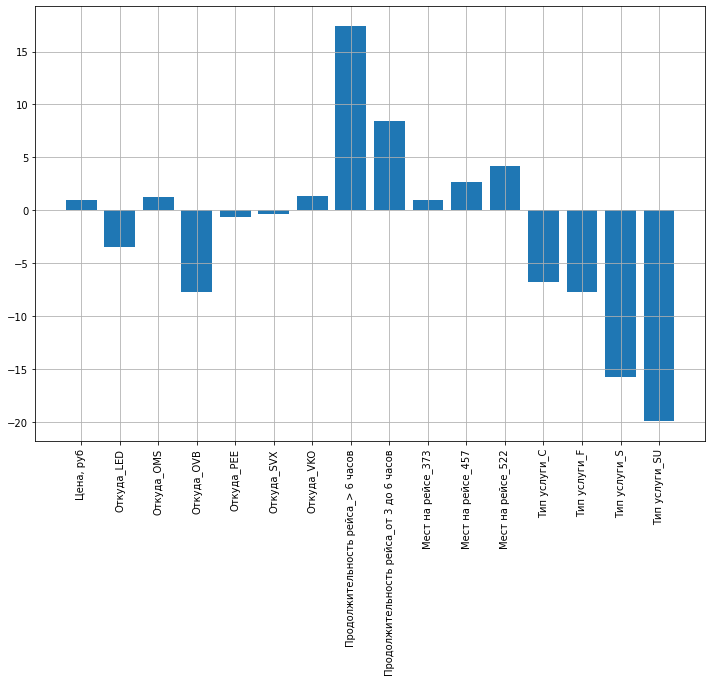

C:\Users\79153\AppData\Local\Temp\ipykernel_22432\2404087743.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score = scores.append({'model' : name,


In [45]:
model = LinearRegression()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
importance = model.coef_
plt.subplots(1,1,figsize = (12,8))
plt.bar(features.columns, importance)
plt.xticks(rotation=90)
plt.grid()
plt.show()
scores = total_results('LinearRegression')

In [46]:
rmse = round((mean_squared_error(y_test, prediction))**0.5, 4)
R2 = round(r2_score(y_test, prediction), 4)
print('''Results for initial data,
RMSE: {}
R2: {}'''.format(rmse,R2))

Results for initial data,
RMSE: 5.8604
R2: 0.7305


#### LGBM <a id='LGBM'></a>

In [47]:
col_ren = {'Фактический спрос': 'sells','Откуда': 'start', 'Продолжительность рейса':'dur','Мест на рейсе': 'places', 'Тип услуги': 'type', 'Цена, руб': 'cost'}

prep_df.rename(columns=col_ren, inplace=True)

features = prep_df.drop(['sells'], axis=1)
target = prep_df['sells']

cols_for_scaler = ['cost']

list_columns = [i for i in features.columns if i not in cols_for_scaler]
for i in list_columns:
    features = get_dummies_func(features, i)


# разбивка данных 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=190)

X_train[cols_for_scaler] = scaler.transform(X_train[cols_for_scaler])
X_test[cols_for_scaler] = scaler.transform(X_test[cols_for_scaler])

D:\Programs\anaconda_2\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
D:\Programs\anaconda_2\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- cost
Feature names seen at fit time, yet now missing:
- Цена, руб

  warnings.warn(message, FutureWarning)
D:\Programs\anaconda_2\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- cost
Feature names seen at fit time, yet now missing:
- Цена, руб

  warnings.warn(message, FutureWarning)


In [48]:
train_data = lightgbm.Dataset(X_train, label=y_train, 
                              free_raw_data=False,
                              categorical_feature=cat_features)
test_data = lightgbm.Dataset(X_test, label=y_test)


cat_features = [col for col in list(X_train.columns) if col not in cols_for_scaler]

param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
              'max_depth': [10, 11, 12, 13, 14]}

grid_search = GridSearchCV(estimator = lightgbm.LGBMRegressor(cat_features = cat_features, n_jobs = -1), 
                           param_grid = param_grid, 
                           cv = 5,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

[LightGBM] [Warning] 6 is set=, 6= will be ignored. Current value: 6=
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Unknown parameter: 6
[LightGBM] [Warning] Unknown parameter: часов,dur_от
[LightGBM] [Warning] Unknown parameter: 3
[LightGBM] [Warning] Unknown parameter: до
[LightGBM] [Warning] Unknown parameter: часов,places_373,places_457,places_522,type_C,type_F,type_S,type_SU
{'learning_rate': 0.05, 'max_depth': 13}


In [49]:
prediction = grid_search.best_estimator_.predict(X_test)
print(f'RMSE for test LightGBM: {round((mean_squared_error(y_test, prediction, squared=False)), 2)}')
print('R2: ',r2_score(y_test, prediction).round(5))
scores = total_results('LGBM')

RMSE for test LightGBM: 5.08
R2:  0.79766


C:\Users\79153\AppData\Local\Temp\ipykernel_22432\2404087743.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score = scores.append({'model' : name,


### Вывод <a id='concl'></a>

В данной работе был выполнен анализ данных, в ходе которого выявлены зависимости:

1. Часть услуг торгуется только при вылете определенными аэропортами.
2. Некоторые услуги доступны только при полетах определенной длительности.
3. Большинство аэропортов принимает только суда типа ВС2. При этом маршруты средней и высокой дальности доступны только ВС1. 
4. Среди числовых данных корреляцию показывает только цена в разрезе длительности полета. Цена услуги определяется в первую очередь пунктом отправки и длительностью полета. Существенного изменения цены во времени нет.
5. Есть отсутствующие данные за определенные периоды времени
6. Услуги имеют различную среднюю конверсию и доступны не на всех аэропортах, типах ВС и дальностях полетов. 

Учитывая сниженную конверсию для A,S и SU на полетах 3-6 часов имеет смысл повысить их рентабельность, например снизив цену за данные услуги.

Для предсказания были выбраны три наиболее распространенные модели - CatBoostRegressor, LGMBRegressor, LinearRegression. 
На выбранном датасете наилучшие показатели удалось достичь модели на основе CatBoost.

In [50]:
scores.set_index('model', drop=True, inplace=True)
scores

,R2,RMSE
model,,
CatBoost,0.80559,4.9776
LinearRegression,0.73051,5.8604
LGBM,0.79766,5.0780


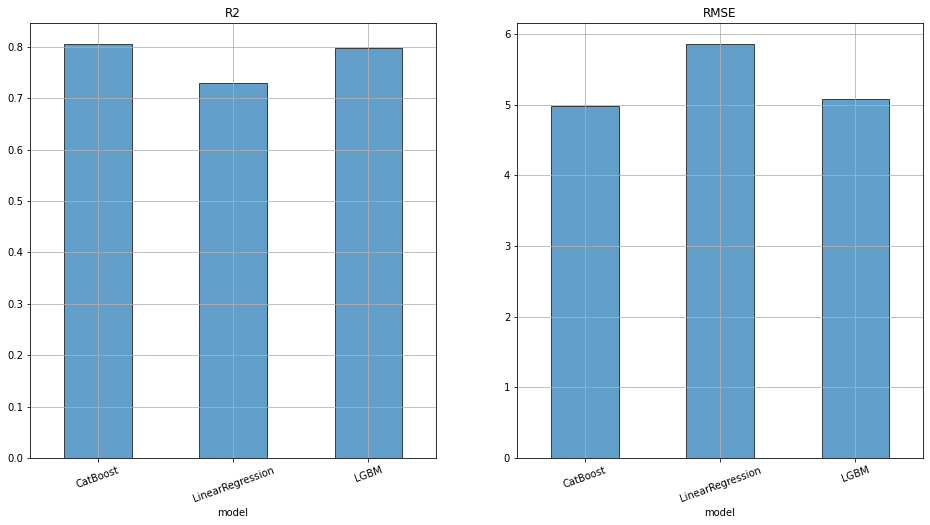

In [51]:
fig,ax = plt.subplots(1,2,figsize = (18,12))
scores['R2'].plot(ax= ax[0], kind='bar', ec='black', rot=20, figsize=(16,8), alpha=0.70, title='R2', grid=True)
scores['RMSE'].plot(ax= ax[1], kind='bar', ec='black', rot=20, figsize=(16,8), alpha=0.70, title='RMSE', grid=True)

plt.show()